# Environment Setup

## Package Installation

In [4]:
# %pip install pandas matplotlib numpy seaborn scikit-learn xgboost patsy statsmodels
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# %pip install seaborn
# %pip install pmdarima
# %pip install tqdm

## Imports and GPU Configuration

In [5]:
# Cell 1 - Environment Setup and Imports
import warnings
import os
warnings.filterwarnings('ignore')

# Essential libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import platform
from scipy import stats

# Time series specific
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# ML/DL libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting settings - using a more reliable approach
plt.style.use('default')  # Reset to default style
sns.set_style("whitegrid")  # Apply seaborn styling
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

def print_gpu_info():
    """
    Print detailed information about GPU configuration
    """
    print("System Information:")
    print(f"Python version: {sys.version}")
    print(f"Platform: {platform.platform()}")
    print(f"PyTorch version: {torch.__version__}")
    
    print("\nGPU Information:")
    if torch.cuda.is_available():
        print(f"GPU Available: Yes")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        print(f"Current GPU: {torch.cuda.current_device()}")
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
        
        # Test GPU with a simple operation
        print("\nTesting GPU...")
        x = torch.randn(1000, 1000).cuda()
        y = torch.matmul(x, x.t())
        print("GPU test successful!")
    else:
        print("No GPU available. Using CPU.")

print_gpu_info()

Using device: cuda
System Information:
Python version: 3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
PyTorch version: 2.5.1+cu121

GPU Information:
GPU Available: Yes
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU
GPU Memory Allocated: 8.12 MB
GPU Memory Reserved: 20.00 MB

Testing GPU...
GPU test successful!


# Data Loading and Preprocessing

- Data Import
- Initial Data Quality Checks
- Missing Values Analysis
- DateTime Index Setup

In [6]:
# Cell 2 - Data Loading and Basic Checks
def load_data(filepath):
    """
    Load and preprocess the time series data
    Parameters:
    filepath (str): Path to the CSV file
    Returns:
    pd.DataFrame: Preprocessed DataFrame with DateTime index
    """
    # Read the CSV file
    df = pd.read_csv(filepath)

    # Try to detect the datetime format automatically
    try:
        df['DateTime'] = pd.to_datetime(df['DateTime'], format='mixed')
    except ValueError as e:
        print(f"Warning: {e}")
        print("Attempting alternative datetime parsing...")
        try:
            df['DateTime'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
        except Exception as e:
            print(f"Error in datetime parsing: {e}")
            raise

    # Set DateTime as index
    df.set_index('DateTime', inplace=True)

    # Sort index to ensure chronological order
    df.sort_index(inplace=True)

    # Display basic information
    print("\nDataset Info:")
    print(df.info())
    print("\nFirst few rows:")
    print(df.head())
    print("\nLast few rows:")
    print(df.tail())
    print("\nBasic statistics:")
    print(df.describe())

    return df

# Load the data
try:
    df = load_data('ts2024.csv')
except Exception as e:
    print(f"Error loading data: {e}")
    raise


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2015-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    17544 non-null  object 
 1   Hour    17544 non-null  int64  
 2   X       16800 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 548.2+ KB
None

First few rows:
                           Date  Hour       X
DateTime                                     
2015-01-01 00:00:00  2015-01-01     0  0.0146
2015-01-01 01:00:00  2015-01-01     1  0.0148
2015-01-01 02:00:00  2015-01-01     2  0.0101
2015-01-01 03:00:00  2015-01-01     3  0.0060
2015-01-01 04:00:00  2015-01-01     4  0.0055

Last few rows:
                           Date  Hour   X
DateTime                                 
2016-12-31 19:00:00  2016-12-31    19 NaN
2016-12-31 20:00:00  2016-12-31    20 NaN
2016-12-31 21:00:00  2016-12-31    21 NaN
2016-12-31 22:00:00  20

In [7]:
# Cell 3 - Data Quality Analysis and Cleaning
def analyze_data_quality(df):
    """
    Perform comprehensive data quality analysis
    """
    print("=== Data Quality Analysis ===")

    # Basic dataset properties
    print("\n1. Dataset Properties:")
    print(f"Time range: {df.index.min()} to {df.index.max()}")
    print(f"Total number of records: {len(df)}")
    print(f"Sampling frequency: {df.index.freq if df.index.freq else 'Inferred hourly'}")

    # Check for duplicates
    duplicates = df.index.duplicated(keep=False)
    if duplicates.any():
        n_duplicates = duplicates.sum()
        print(f"\nWarning: Found {n_duplicates} duplicate timestamps!")
        print("\nExample of duplicates:")
        print(df[duplicates].sort_index().head())

    # Check for time series continuity
    expected_periods = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_periods = set(expected_periods) - set(df.index)

    print("\n2. Time Series Continuity:")
    print(f"Number of missing timestamps: {len(missing_periods)}")
    if missing_periods:
        print("Sample of missing timestamps:")
        print(sorted(list(missing_periods))[:5])

    # Value distribution analysis
    print("\n3. Value Distribution (X):")
    print(df['X'].describe())

    # Outlier detection
    Q1 = df['X'].quantile(0.25)
    Q3 = df['X'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['X'] < (Q1 - 1.5 * IQR)) | (df['X'] > (Q3 + 1.5 * IQR))]

    print("\n4. Outlier Analysis:")
    print(f"Number of potential outliers: {len(outliers)}")
    if len(outliers) > 0:
        print("Sample of outliers:")
        print(outliers.head())

    # Missing data patterns
    print("\n5. Missing Data Patterns:")
    missing_by_month = df['X'].isna().groupby(df.index.month).sum()
    print("Missing values by month:")
    print(missing_by_month)

    return missing_periods, outliers, duplicates

def clean_data(df, duplicates):
    """
    Clean the data by:
    1. Handling duplicates by taking their mean
    2. Filling ONLY the two specific missing timestamps in historical data
    3. Keeping the last 744 values as missing for forecasting
    """
    print("=== Data Cleaning ===")
    
    df_cleaned = df.copy()
    
    # Step 1: Handle duplicates by taking the mean of X values for same timestamps
    if duplicates.any():
        print("\nHandling duplicates by taking the mean value for each timestamp...")
        df_cleaned = df_cleaned.groupby(level=0).agg({
            'Date': 'first',  # Keep first date string
            'Hour': 'first',  # Keep first hour
            'X': 'mean'      # Take mean of X values
        })
        print(f"After handling duplicates: {len(df_cleaned)} rows")
    
    # Step 2: Handle ONLY the two specific missing timestamps
    specific_missing = pd.to_datetime(['2015-03-29 02:00:00', '2016-03-27 02:00:00'])
    
    for timestamp in specific_missing:
        if timestamp in df_cleaned.index:
            continue
            
        # Get the same hour from the day before and after
        prev_day = df_cleaned.loc[timestamp - pd.Timedelta(days=1):timestamp - pd.Timedelta(days=1), 'X'].iloc[0]
        next_day = df_cleaned.loc[timestamp + pd.Timedelta(days=1):timestamp + pd.Timedelta(days=1), 'X'].iloc[0]
        
        # Create new row with interpolated value
        df_cleaned.loc[timestamp] = {
            'Date': timestamp.date(),
            'Hour': timestamp.hour,
            'X': (prev_day + next_day) / 2
        }
    
    # Sort index to ensure chronological order
    df_cleaned.sort_index(inplace=True)
    
    # Verify the cleaning worked correctly
    print("\nVerification after cleaning:")
    n_missing = df_cleaned['X'].isna().sum()
    print(f"Total missing values (should be 744): {n_missing}")
    
    if n_missing != 744:
        raise ValueError(f"ERROR: Expected 744 missing values, but found {n_missing}")
        
    return df_cleaned

# Analyze and clean data
missing_periods, outliers, duplicates = analyze_data_quality(df)

=== Data Quality Analysis ===

1. Dataset Properties:
Time range: 2015-01-01 00:00:00 to 2016-12-31 23:00:00
Total number of records: 17544
Sampling frequency: Inferred hourly


Example of duplicates:
                           Date  Hour       X
DateTime                                     
2015-10-25 02:00:00  2015-10-25     2  0.0060
2015-10-25 02:00:00  2015-10-25     2  0.0053
2016-10-30 02:00:00  2016-10-30     2  0.0072
2016-10-30 02:00:00  2016-10-30     2  0.0062

2. Time Series Continuity:
Number of missing timestamps: 2
Sample of missing timestamps:
[Timestamp('2015-03-29 02:00:00'), Timestamp('2016-03-27 02:00:00')]

3. Value Distribution (X):
count    16800.000000
mean         0.046320
std          0.048945
min          0.000000
25%          0.018200
50%          0.036800
75%          0.053800
max          0.450000
Name: X, dtype: float64

4. Outlier Analysis:
Number of potential outliers: 1010
Sample of outliers:
                           Date  Hour       X
DateTime     

In [8]:
df = clean_data(df, duplicates)

=== Data Cleaning ===

Handling duplicates by taking the mean value for each timestamp...
After handling duplicates: 17542 rows

Verification after cleaning:
Total missing values (should be 744): 744


In [9]:
# Cell 4 - Data Preprocessing and Feature Engineering
def preprocess_data(df):
    """
    Preprocess the time series data and engineer features
    """
    print("=== Data Preprocessing and Feature Engineering ===")

    # Create a copy to avoid modifying original data
    df_processed = df.copy()

    # Add time-based features
    df_processed['hour'] = df_processed.index.hour
    df_processed['day_of_week'] = df_processed.index.dayofweek
    df_processed['month'] = df_processed.index.month
    df_processed['is_weekend'] = df_processed.index.dayofweek.isin([5, 6]).astype(int)

    # Calculate rolling statistics (excluding the missing period)
    non_missing = df_processed[df_processed['X'].notna()]
    df_processed['rolling_mean_24h'] = non_missing['X'].rolling(window=24, min_periods=1).mean()
    df_processed['rolling_std_24h'] = non_missing['X'].rolling(window=24, min_periods=1).std()

    # Print summary of changes
    print("\nAdded features:")
    for col in df_processed.columns:
        print(f"- {col}")

    print("\nProcessing Summary:")
    print(f"Original shape: {df.shape}")
    print(f"Processed shape: {df_processed.shape}")

    return df_processed

# Preprocess the data
df_processed = preprocess_data(df)

=== Data Preprocessing and Feature Engineering ===

Added features:
- Date
- Hour
- X
- hour
- day_of_week
- month
- is_weekend
- rolling_mean_24h
- rolling_std_24h

Processing Summary:
Original shape: (17544, 3)
Processed shape: (17544, 9)


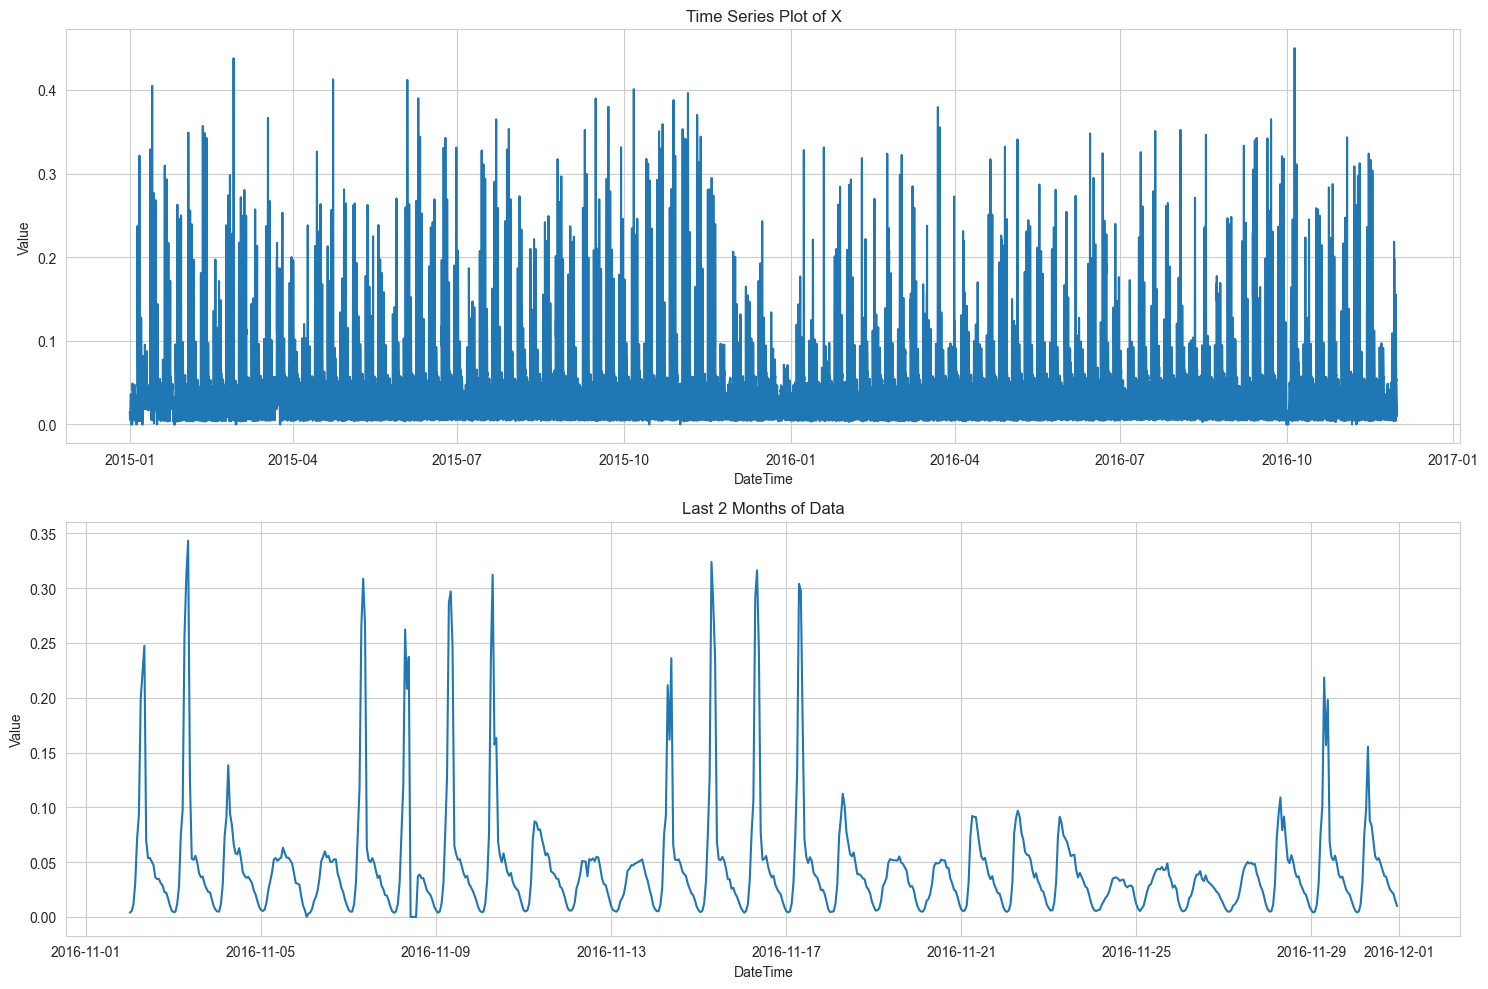

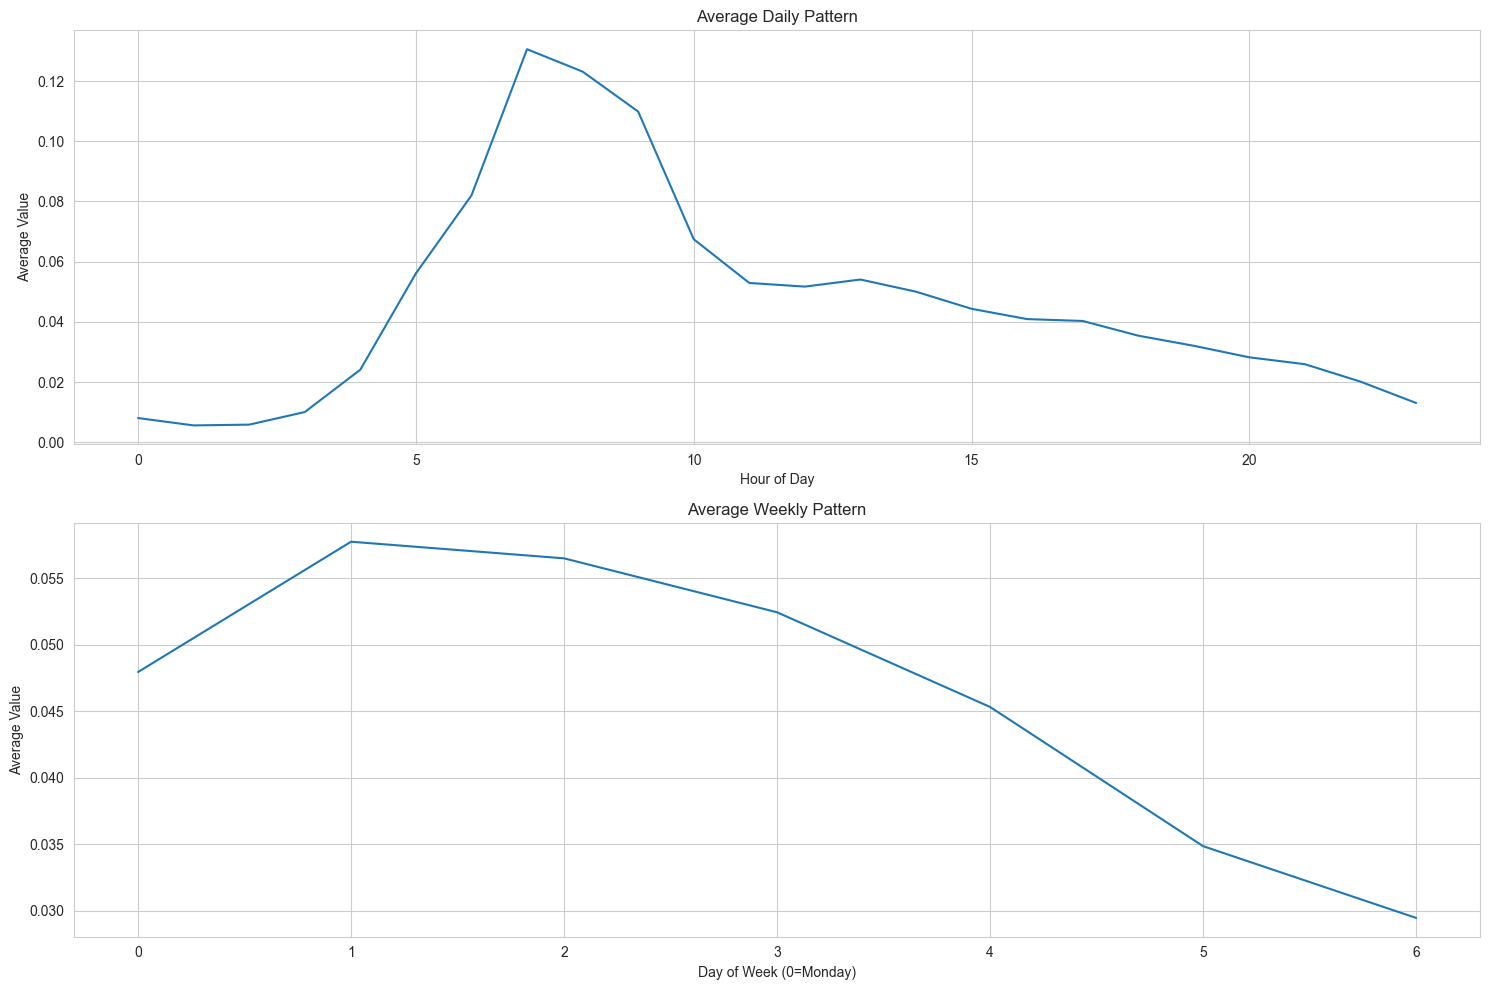

In [10]:
# Cell 5 - Initial Visualizations
def plot_time_series(df):
    """
    Create initial visualizations of the time series data
    """
    # Plot the entire time series
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(df.index, df['X'])
    plt.title('Time Series Plot of X')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.grid(True)

    # Plot the last 2 months of data
    last_2_months = df.last('60D')
    plt.subplot(2, 1, 2)
    plt.plot(last_2_months.index, last_2_months['X'])
    plt.title('Last 2 Months of Data')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_patterns(df):
    """
    Plot daily and weekly patterns
    """
    plt.figure(figsize=(15, 10))

    # Daily pattern
    plt.subplot(2, 1, 1)
    daily_pattern = df.groupby(df.index.hour)['X'].mean()
    plt.plot(daily_pattern.index, daily_pattern.values)
    plt.title('Average Daily Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Value')
    plt.grid(True)

    # Weekly pattern
    plt.subplot(2, 1, 2)
    weekly_pattern = df.groupby(df.index.dayofweek)['X'].mean()
    plt.plot(weekly_pattern.index, weekly_pattern.values)
    plt.title('Average Weekly Pattern')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Average Value')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Create visualizations
plot_time_series(df)
plot_patterns(df)

=== Stationarity Analysis ===
ADF Statistic: -15.709489956924452
p-value: 1.3650064331681149e-28
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


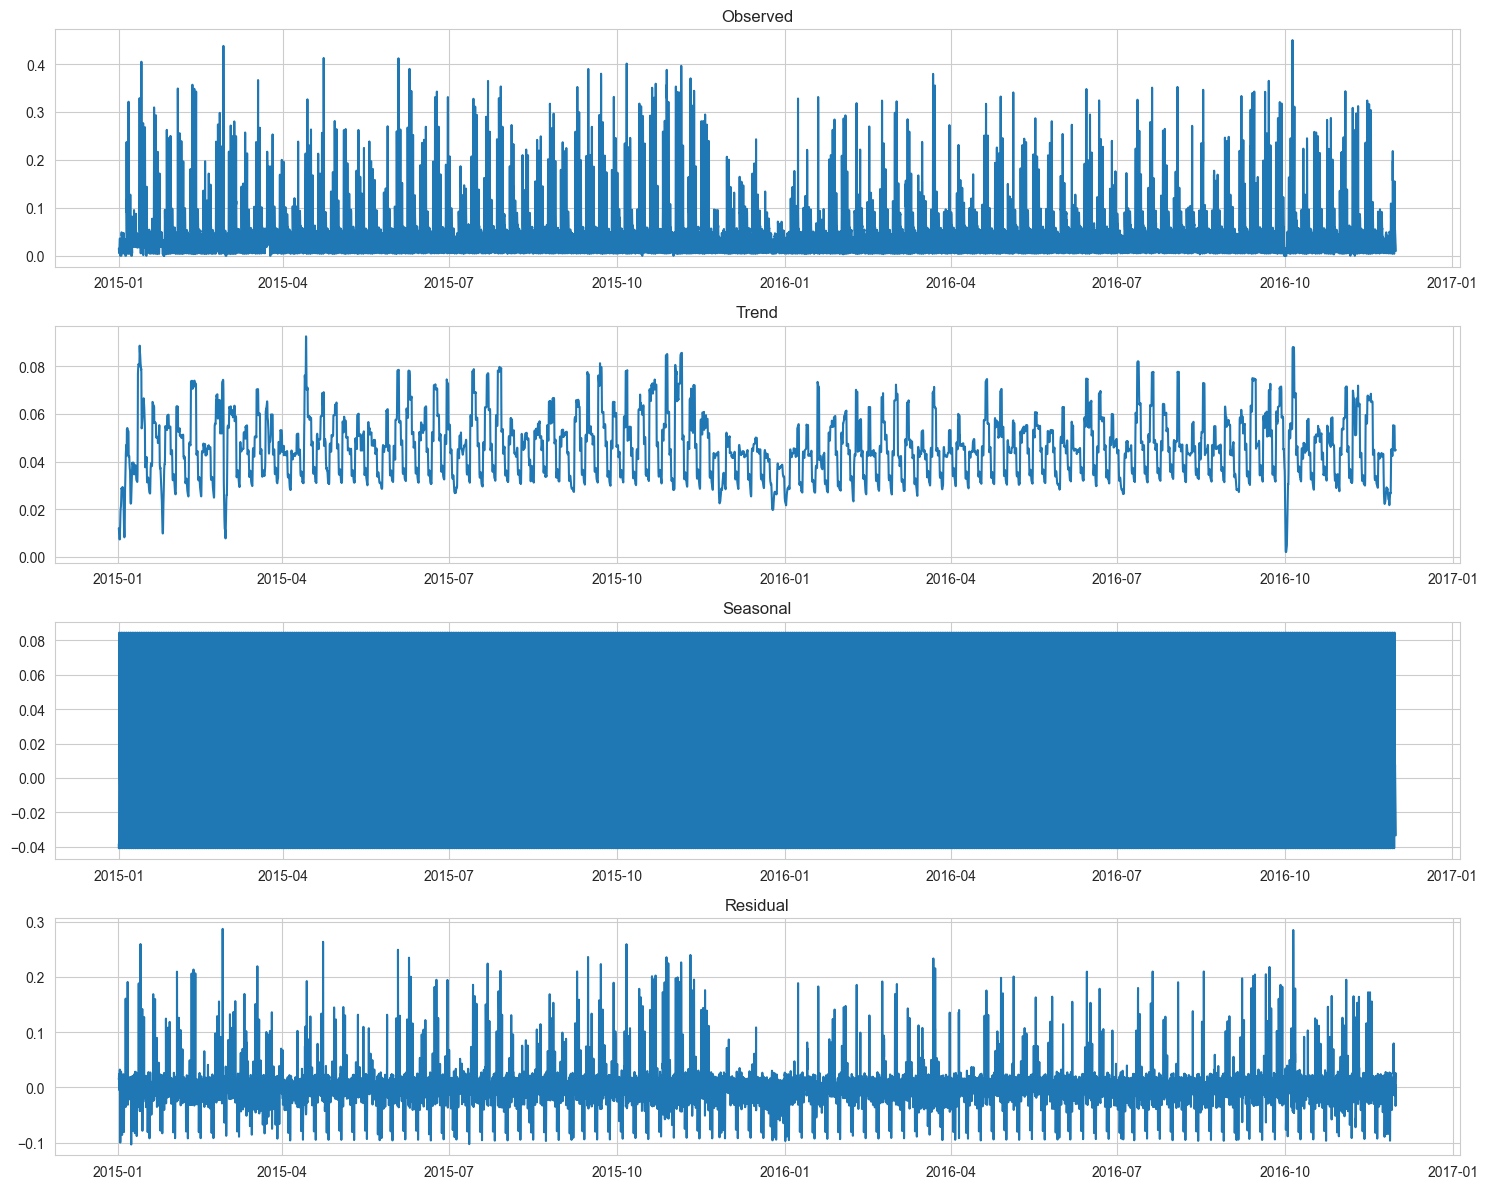

In [11]:
# Cell 6 - Statistical Analysis
def analyze_stationarity(series):
    """
    Perform stationarity analysis and seasonal decomposition
    """
    # Stationarity test
    print("=== Stationarity Analysis ===")
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # Seasonal decomposition
    decomposition = seasonal_decompose(series.dropna(), period=24)  # 24 hours for daily seasonality

    # Plot decomposition
    plt.figure(figsize=(15, 12))
    plt.subplot(411)
    plt.plot(decomposition.observed)
    plt.title('Observed')
    plt.subplot(412)
    plt.plot(decomposition.trend)
    plt.title('Trend')
    plt.subplot(413)
    plt.plot(decomposition.seasonal)
    plt.title('Seasonal')
    plt.subplot(414)
    plt.plot(decomposition.resid)
    plt.title('Residual')
    plt.tight_layout()
    plt.show()

    return decomposition

# Perform statistical analysis
decomposition = analyze_stationarity(df['X'])

=== Advanced Time Series Analysis ===

Analyzing multiple seasonality patterns...


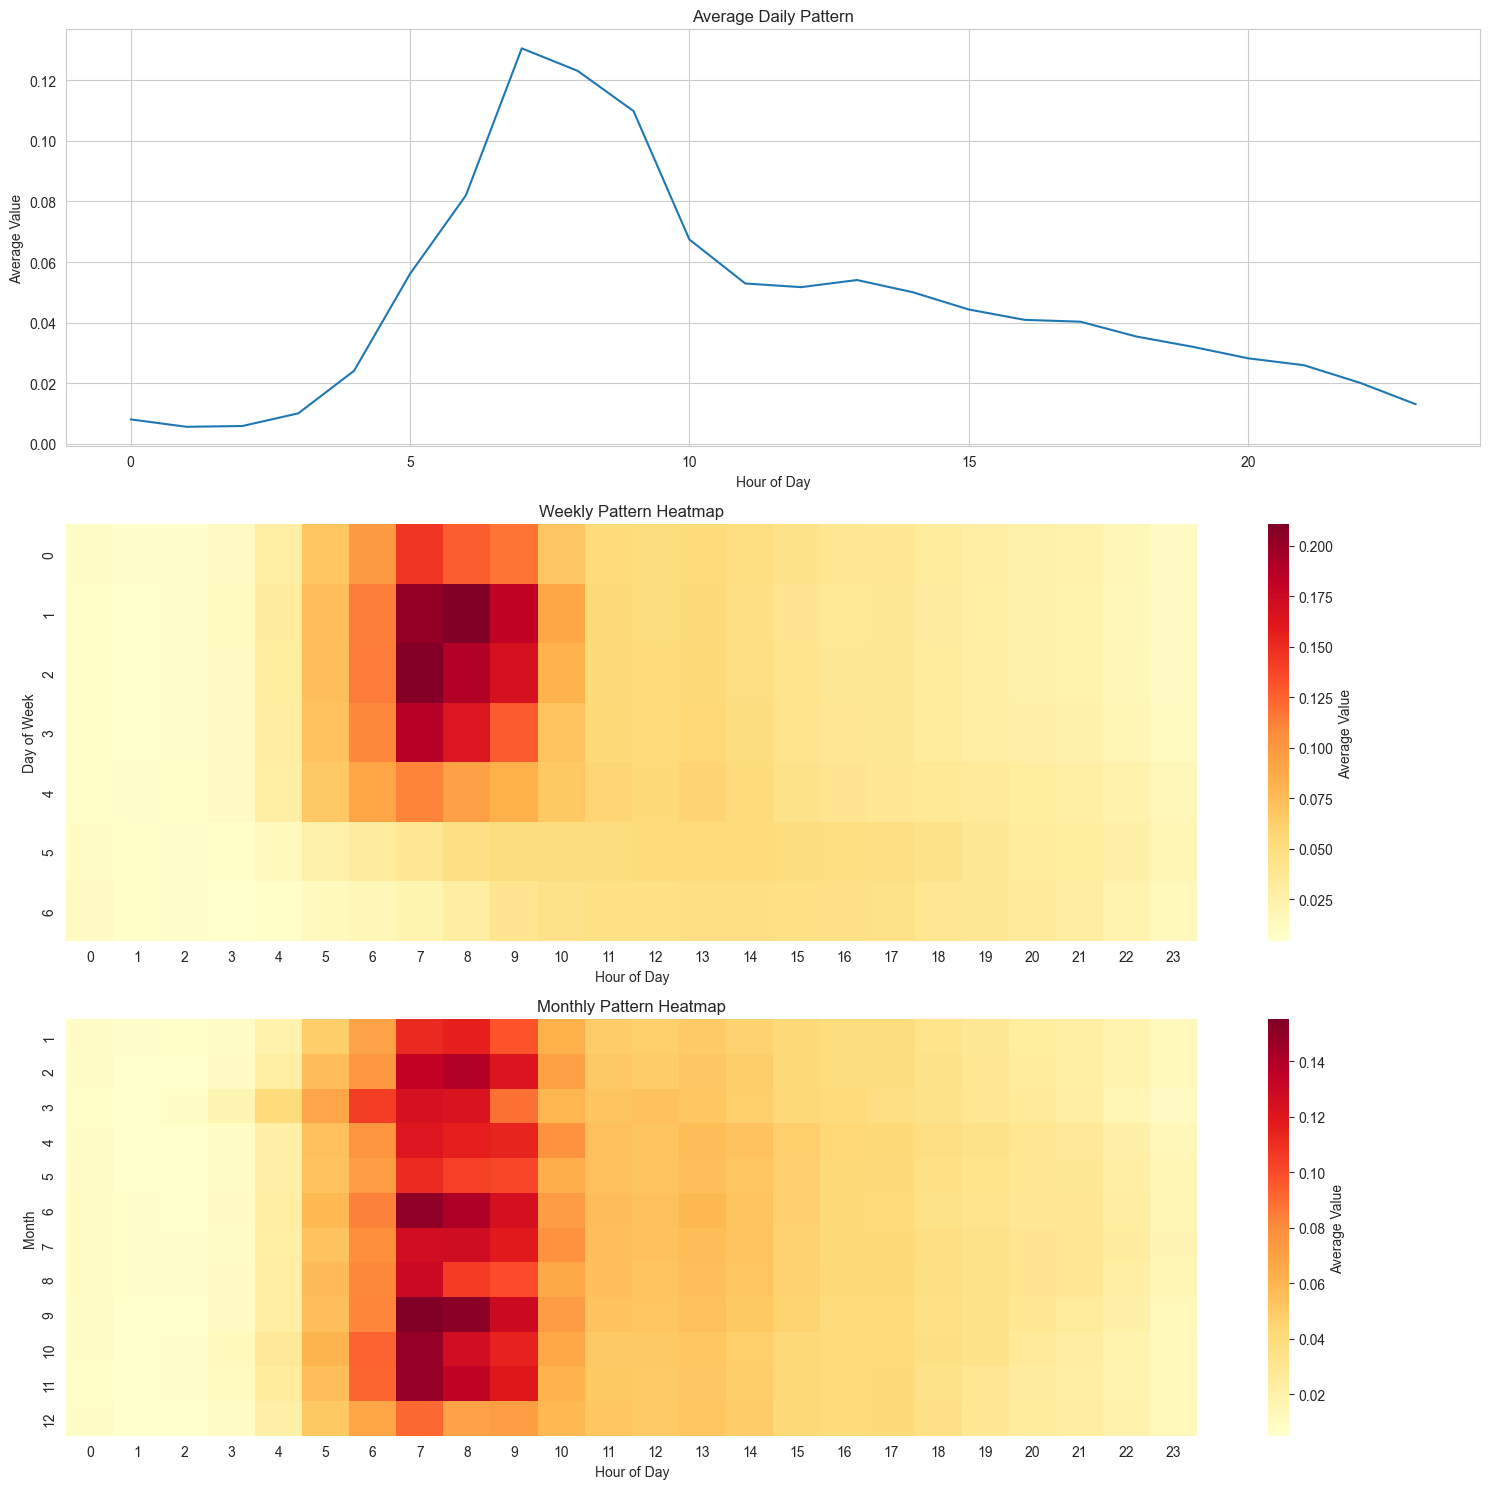

In [12]:
# Cell 7 - Advanced Time Series Analysis
print("=== Advanced Time Series Analysis ===")

def plot_acf_pacf(series, lags=40):
    """
    Plot ACF and PACF for the time series
    """
    plt.figure(figsize=(15, 10))
    
    # Plot ACF
    plt.subplot(211)
    plot_acf(series.dropna(), lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function')
    
    # Plot PACF
    plt.subplot(212)
    plot_pacf(series.dropna(), lags=lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function')
    
    plt.tight_layout()
    plt.show()

def analyze_multiple_seasonality(df):
    """
    Analyze multiple seasonal patterns in the data
    """
    # Daily seasonality
    daily_pattern = df.groupby(df.index.hour)['X'].mean()
    
    # Weekly seasonality
    weekly_pattern = df.groupby([df.index.dayofweek, df.index.hour])['X'].mean()
    weekly_pattern = weekly_pattern.unstack()
    
    # Monthly seasonality
    monthly_pattern = df.groupby([df.index.month, df.index.hour])['X'].mean()
    monthly_pattern = monthly_pattern.unstack()
    
    # Plotting
    fig = plt.figure(figsize=(15, 15))
    
    # Daily pattern
    plt.subplot(311)
    daily_pattern.plot()
    plt.title('Average Daily Pattern')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Value')
    
    # Weekly pattern
    plt.subplot(312)
    sns.heatmap(weekly_pattern, cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
    plt.title('Weekly Pattern Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    
    # Monthly pattern
    plt.subplot(313)
    sns.heatmap(monthly_pattern, cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
    plt.title('Monthly Pattern Heatmap')
    plt.xlabel('Hour of Day')
    plt.ylabel('Month')
    
    plt.tight_layout()
    plt.show()
    
    return daily_pattern, weekly_pattern, monthly_pattern

# Execute the functions
print("\nAnalyzing multiple seasonality patterns...")
daily_pattern, weekly_pattern, monthly_pattern = analyze_multiple_seasonality(df)



=== ACF and PACF Analysis of Original Series ===


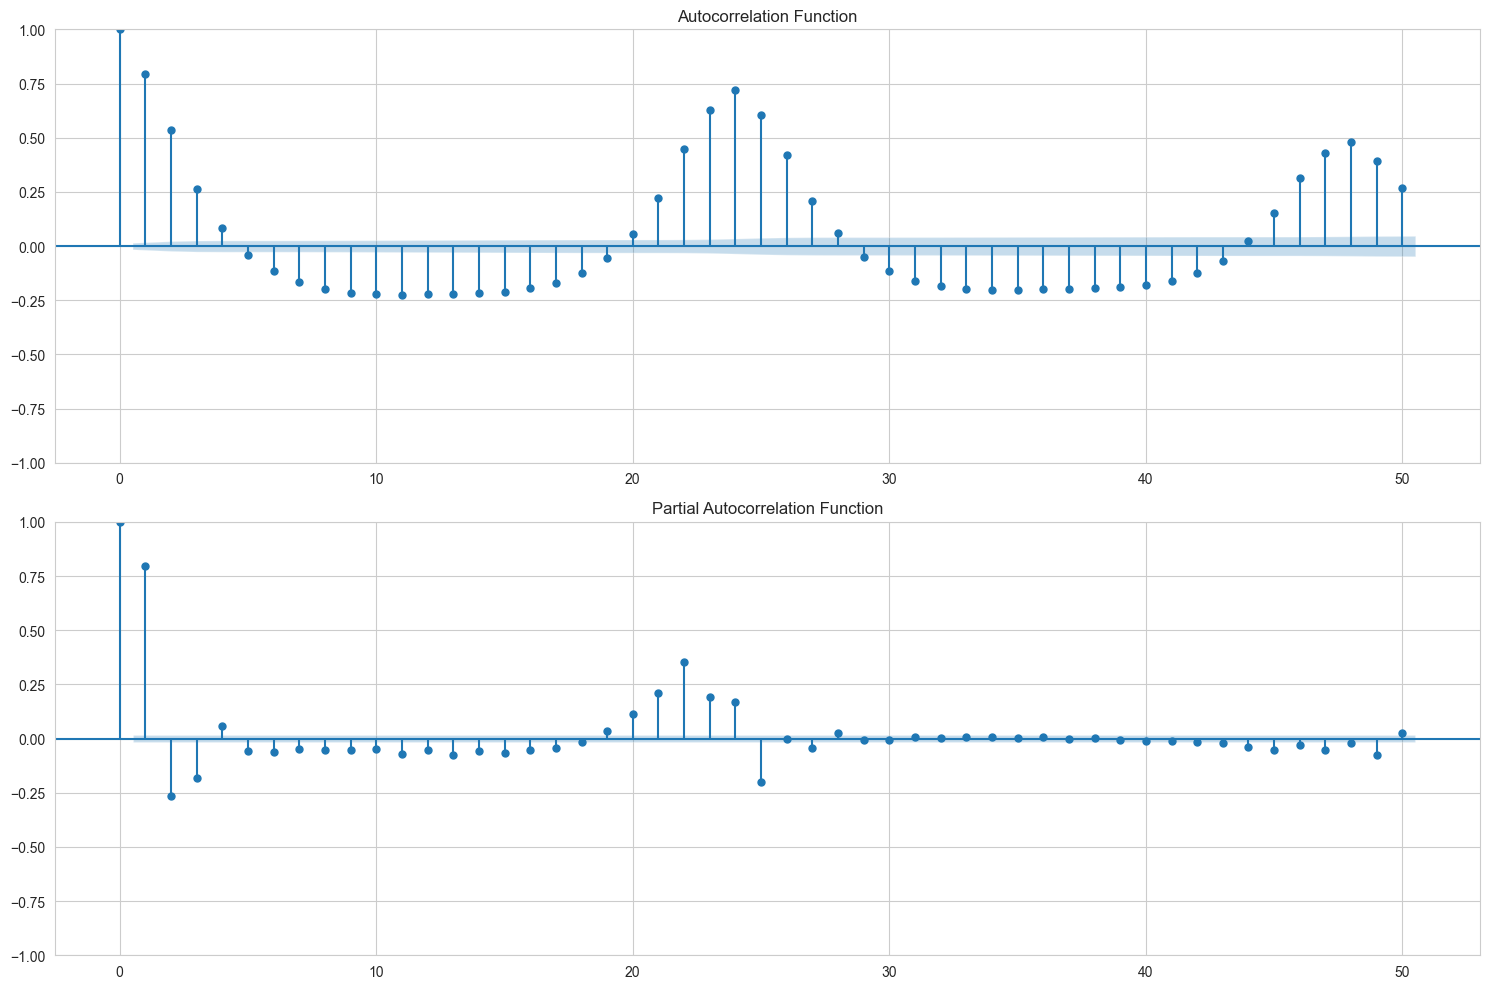


=== ACF and PACF Analysis of First Difference ===


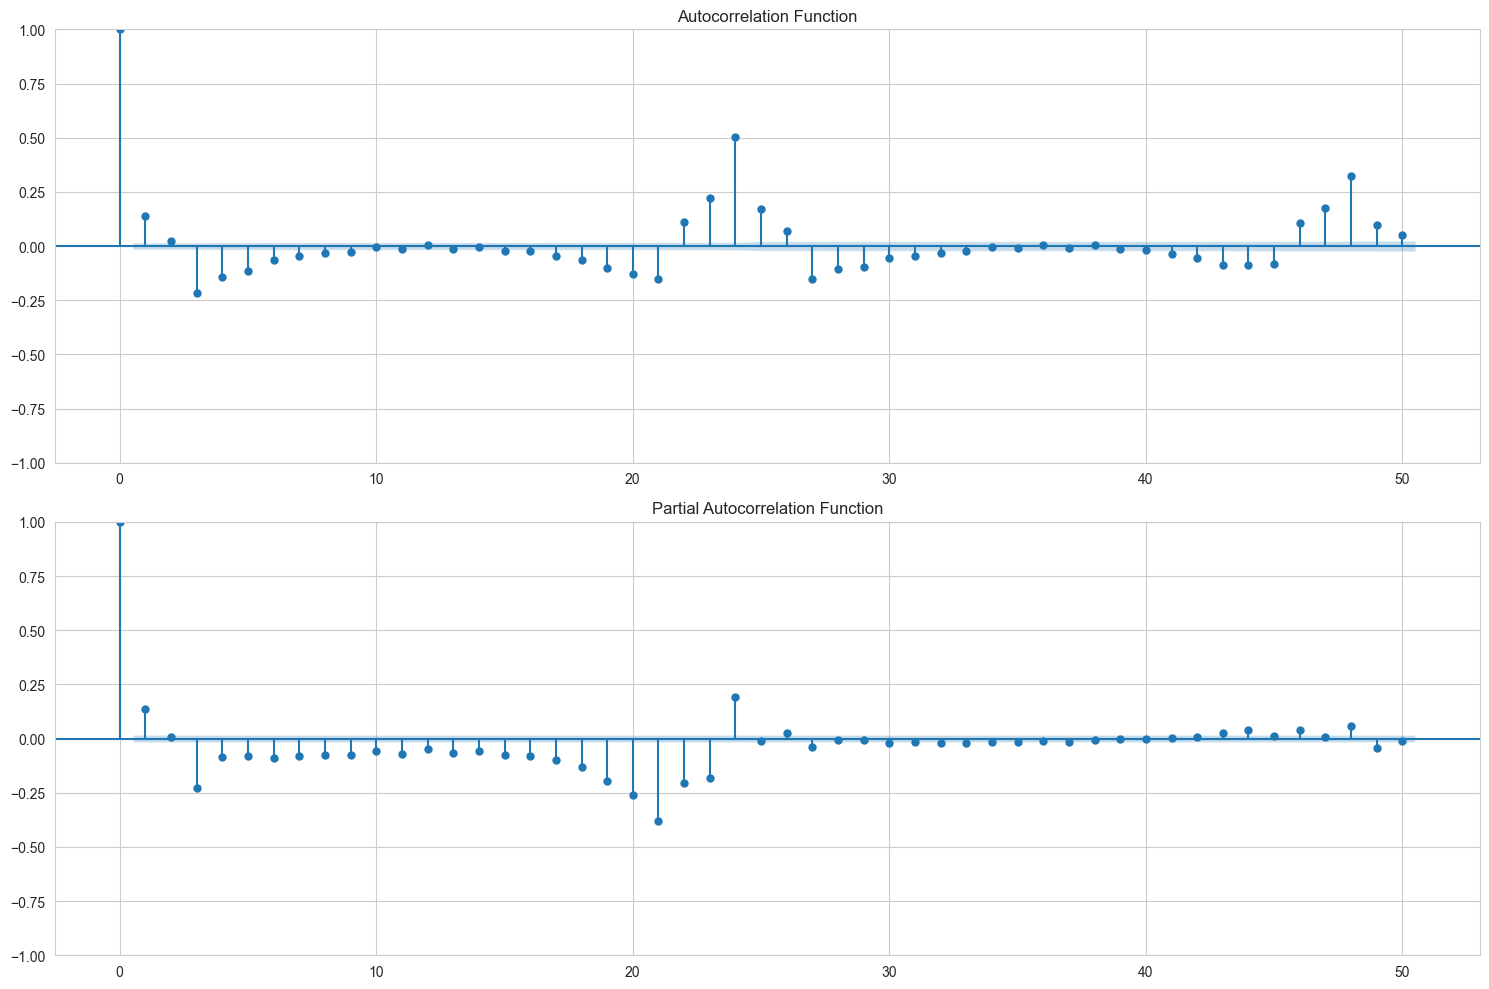


=== ACF and PACF Analysis of Seasonal Difference (24 hours) ===


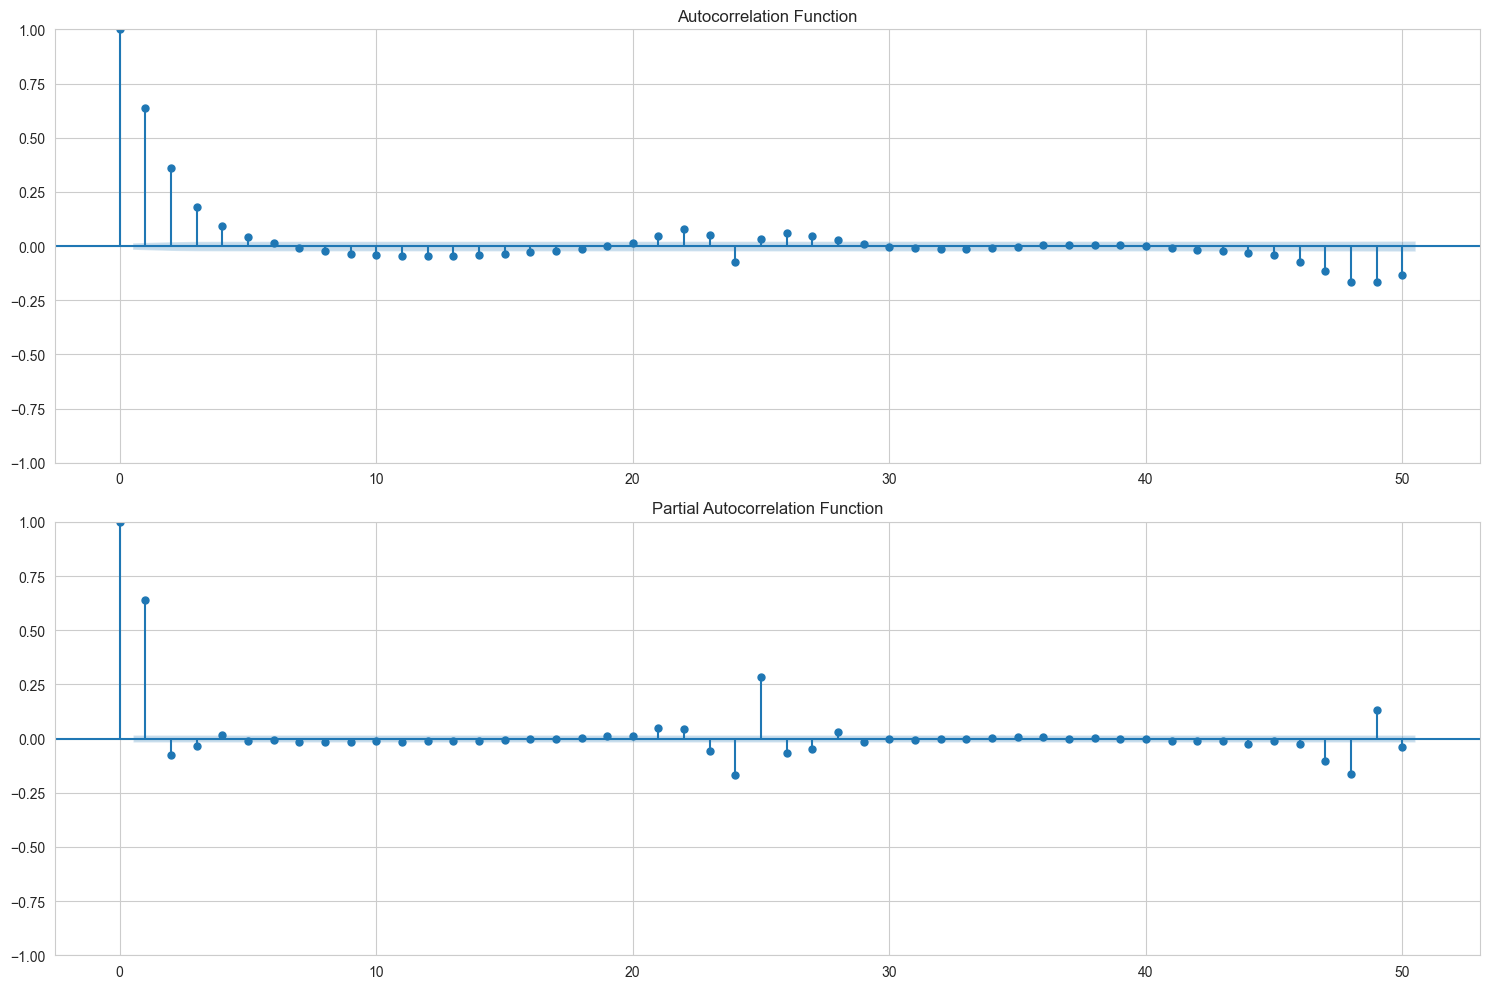


=== ACF and PACF Analysis of First and Seasonal Differences Combined ===


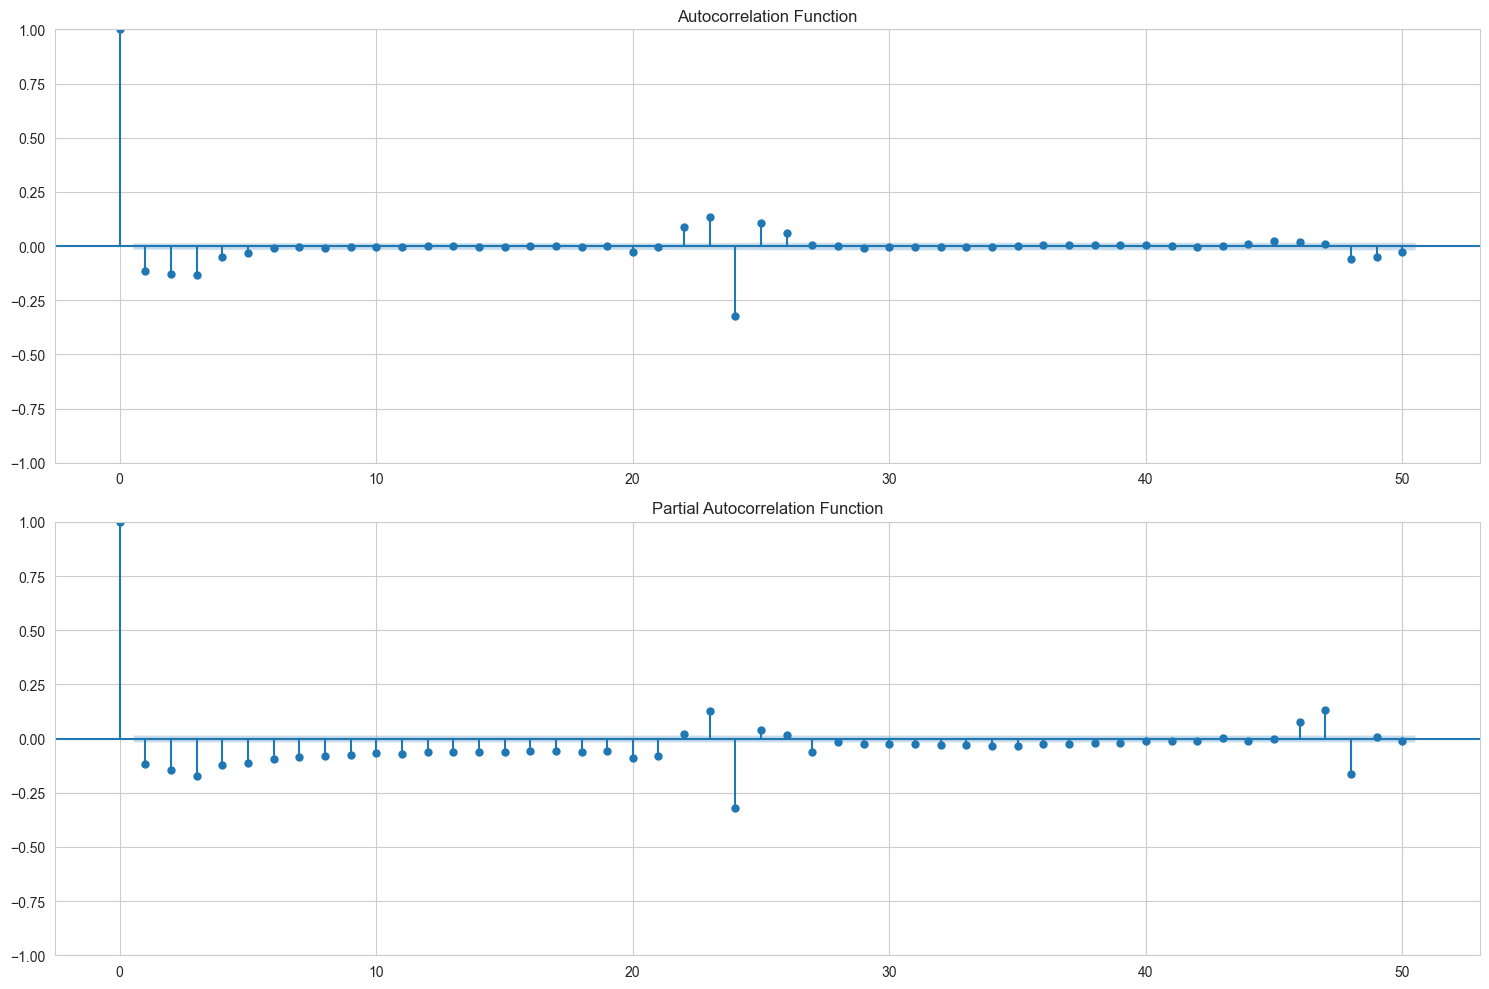


Statistics for Original Series:
Mean: 0.0463
Std: 0.0489
ADF Test p-value: 0.0000

Statistics for First Difference:
Mean: -0.0000
Std: 0.0313
ADF Test p-value: 0.0000

Statistics for Seasonal Difference:
Mean: 0.0000
Std: 0.0367
ADF Test p-value: 0.0000

Statistics for Both Differences:
Mean: 0.0000
Std: 0.0313
ADF Test p-value: 0.0000


In [13]:
# Cell 8 - ACF and PACF Analysis

# First, let's analyze the original series
print("=== ACF and PACF Analysis of Original Series ===")
plot_acf_pacf(df['X'], lags=50)

# Now let's look at first difference
print("\n=== ACF and PACF Analysis of First Difference ===")
diff1 = df['X'].diff().dropna()
plot_acf_pacf(diff1, lags=50)

# Let's also look at seasonal difference (24-hour seasonality)
print("\n=== ACF and PACF Analysis of Seasonal Difference (24 hours) ===")
seasonal_diff = df['X'].diff(24).dropna()
plot_acf_pacf(seasonal_diff, lags=50)

# And finally, both differences combined
print("\n=== ACF and PACF Analysis of First and Seasonal Differences Combined ===")
both_diff = seasonal_diff.diff().dropna()
plot_acf_pacf(both_diff, lags=50)

# Let's also show some statistics about each transformation
def print_series_stats(series, name):
    print(f"\nStatistics for {name}:")
    print(f"Mean: {series.mean():.4f}")
    print(f"Std: {series.std():.4f}")
    print(f"ADF Test p-value: {adfuller(series.dropna())[1]:.4f}")

print_series_stats(df['X'], "Original Series")
print_series_stats(diff1, "First Difference")
print_series_stats(seasonal_diff, "Seasonal Difference")
print_series_stats(both_diff, "Both Differences")

=== ACF and PACF Analysis of Original Series ===

Short-term patterns (2 days):


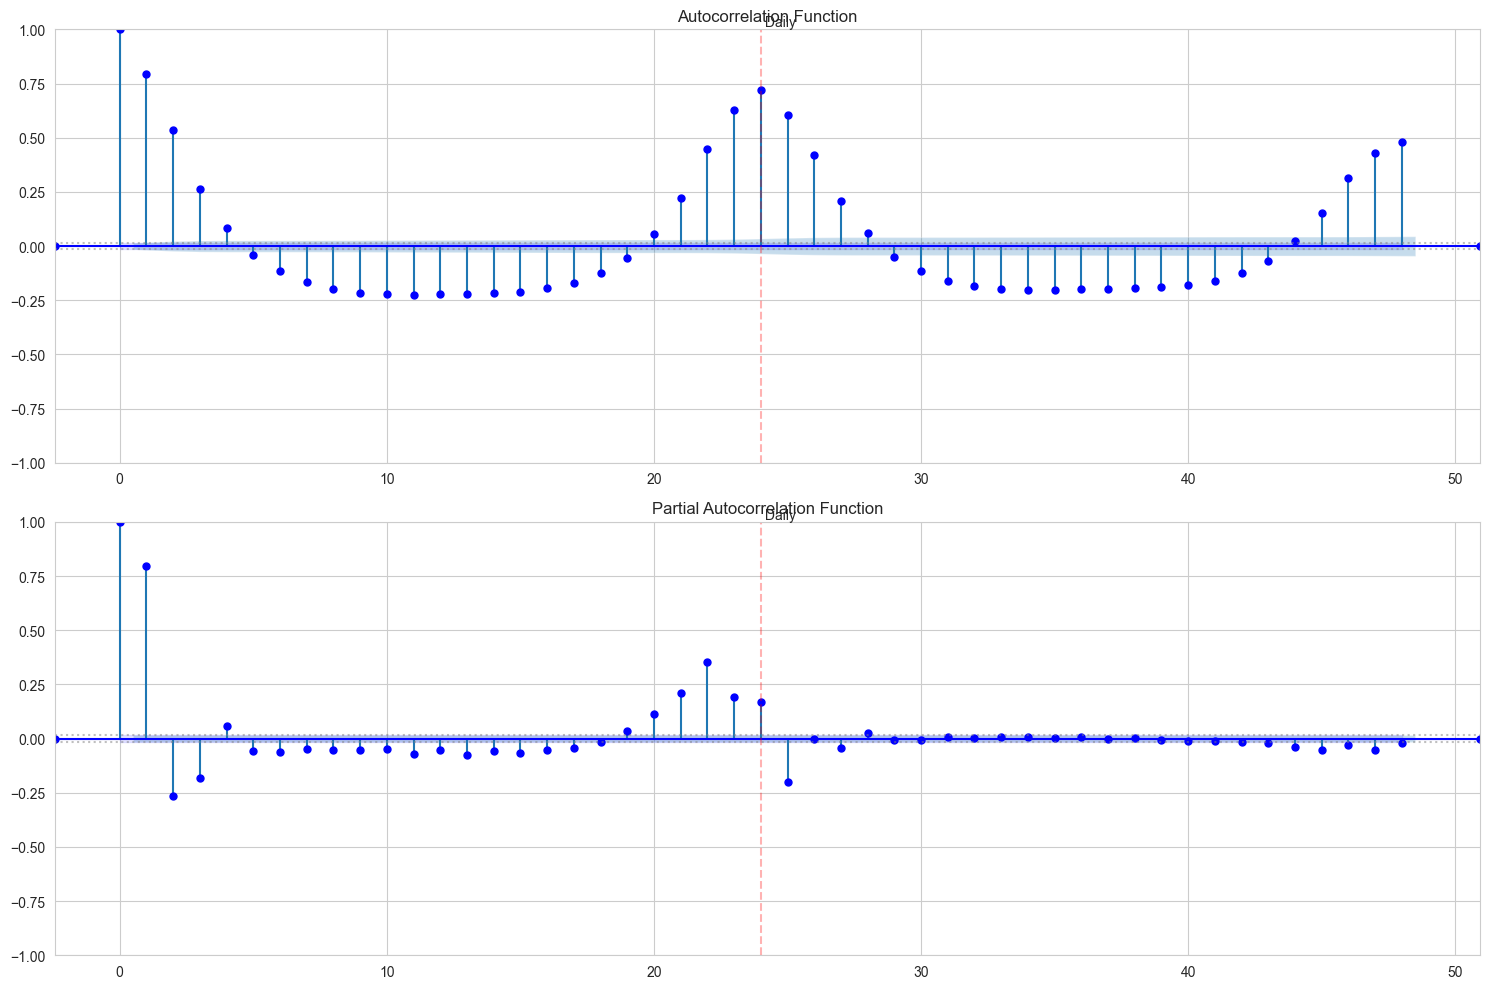


Medium-term patterns (2 weeks):


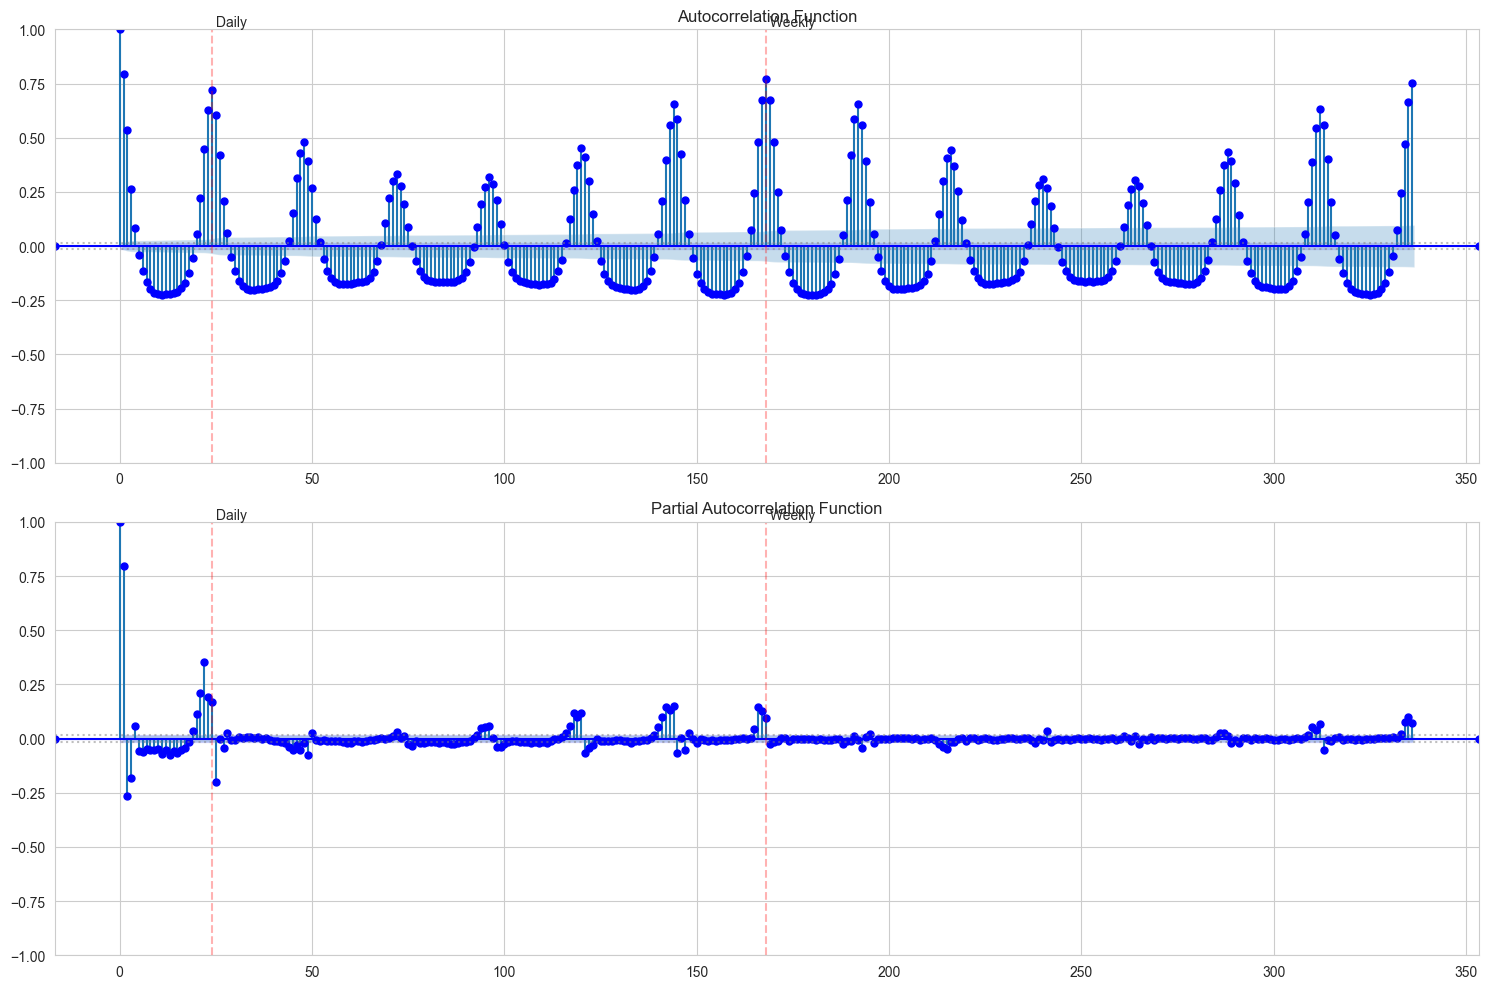


Long-term patterns (1 month):


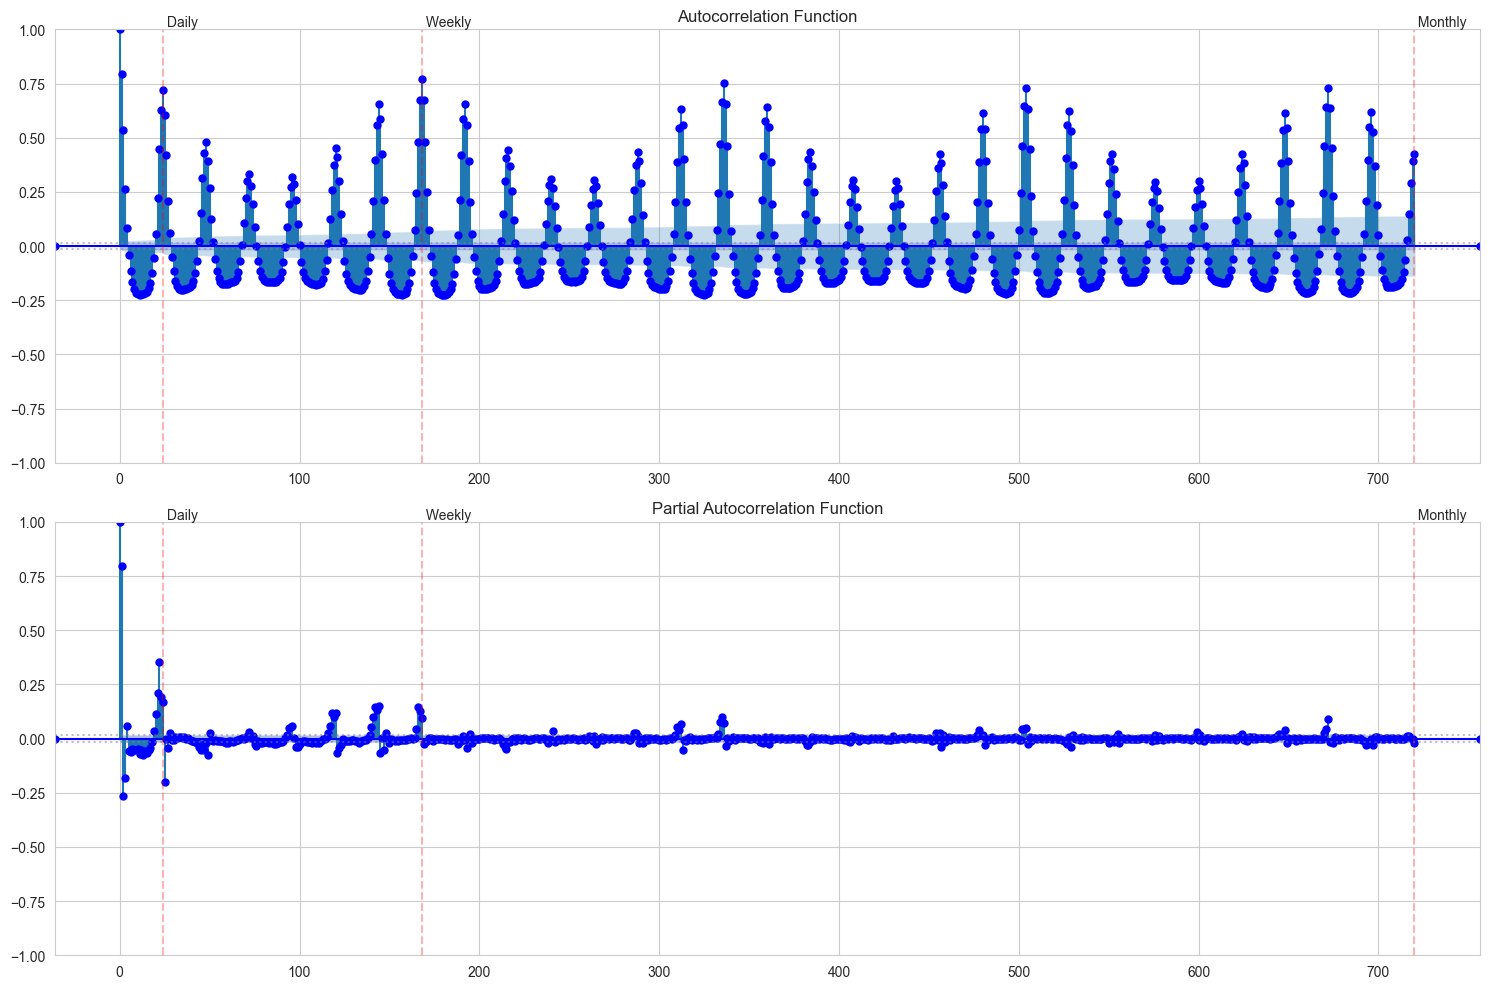


=== ACF and PACF Analysis of Differenced Series ===

First Difference:


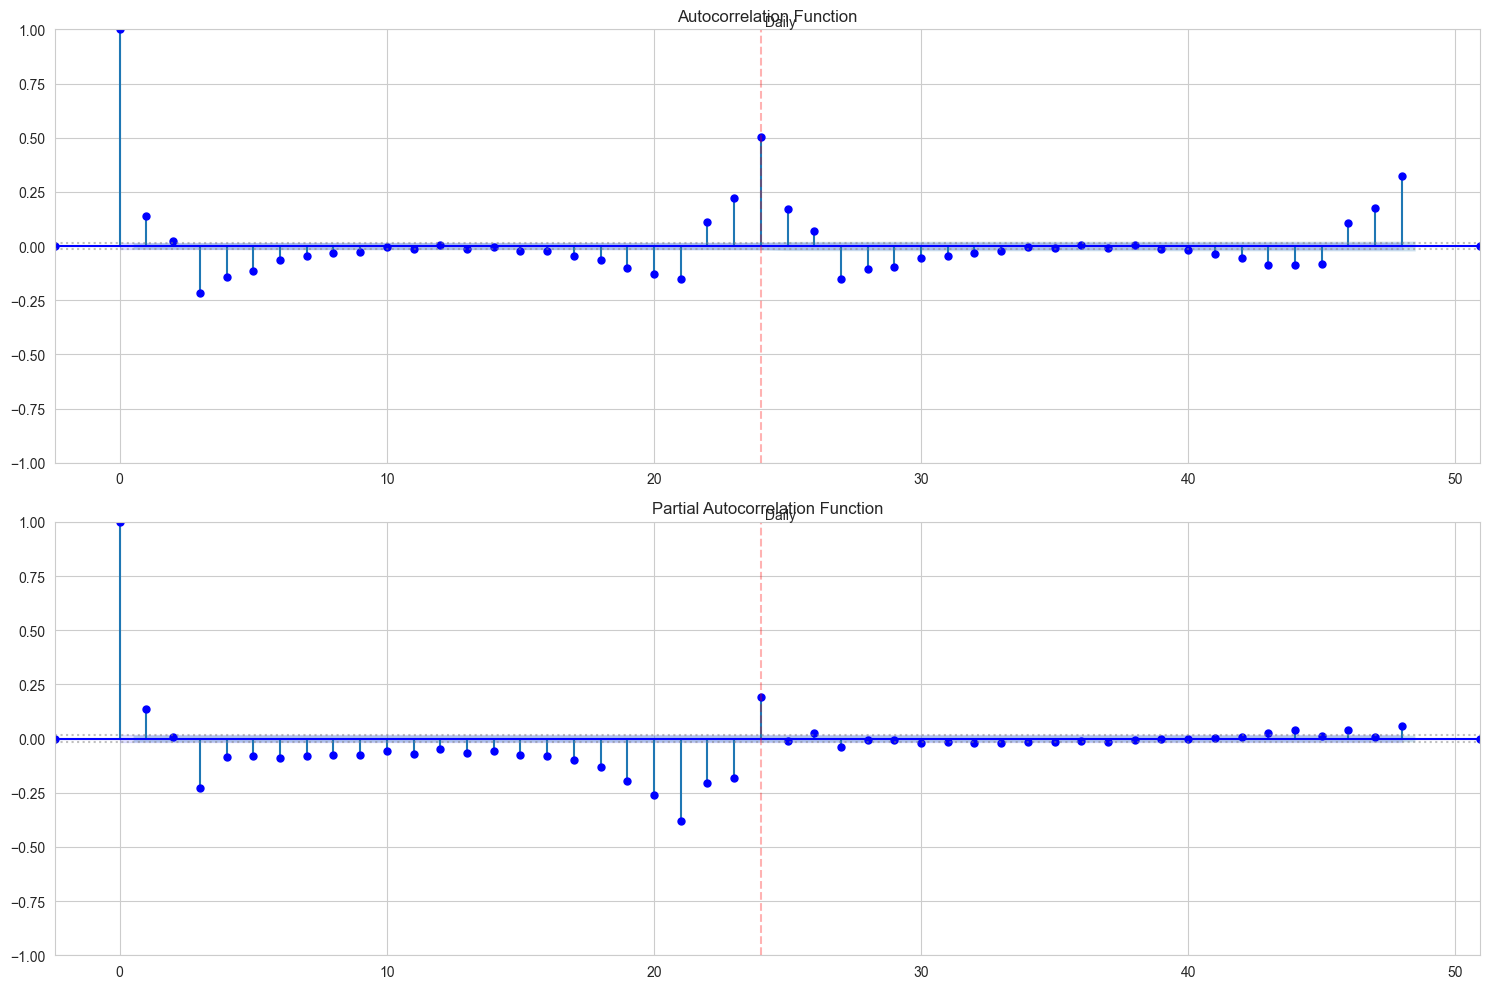


Seasonal Difference (24 hours):


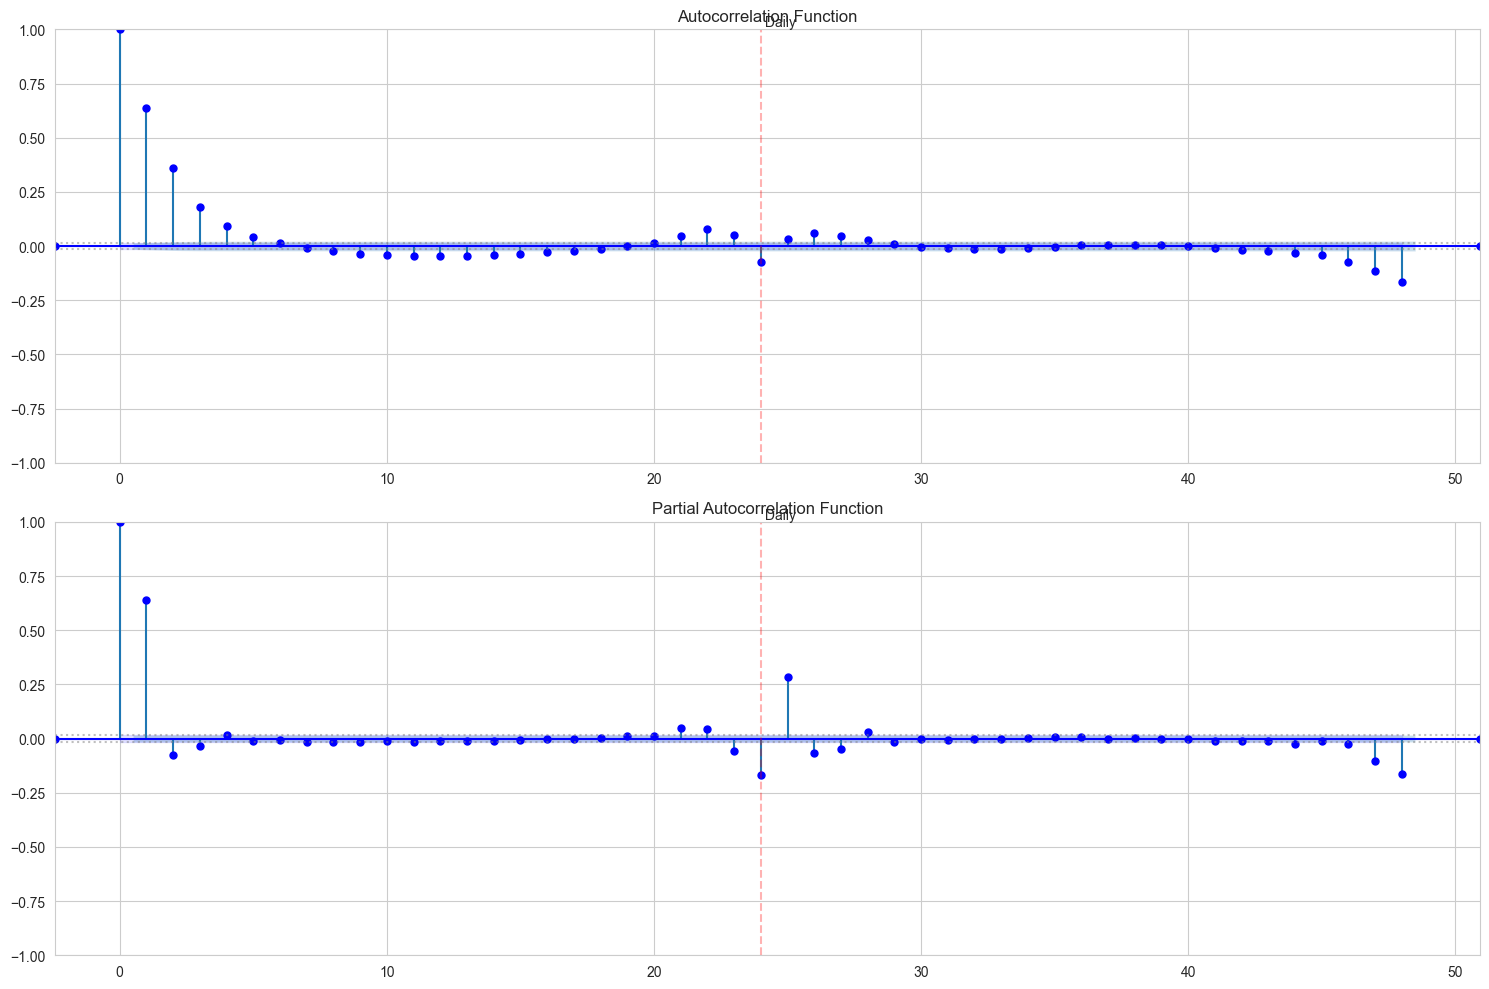


Both Differences Combined:


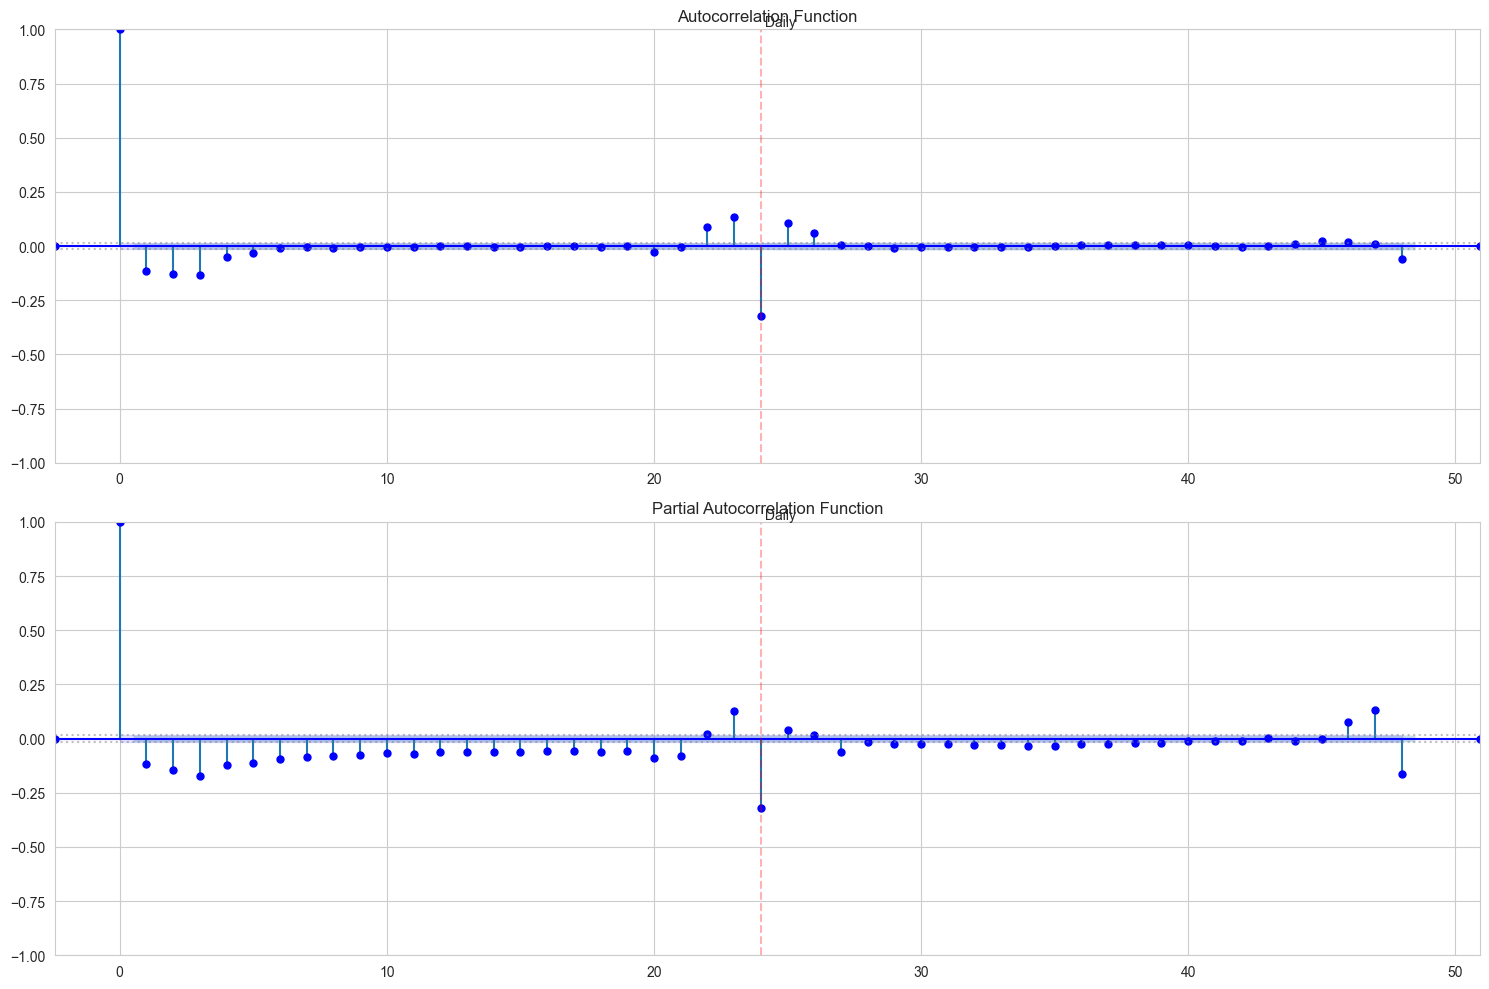

In [14]:
# Cell 8 - Updated ACF and PACF Analysis

def plot_advanced_acf_pacf(series, max_lags=None, periods=None):
    """
    Plot ACF and PACF with multiple lag ranges and highlighted seasonal periods
    
    Parameters:
    - series: time series data
    - max_lags: maximum number of lags to show
    - periods: list of tuples (period, label) to highlight
    """
    if max_lags is None:
        max_lags = 24 * 8  # Show 8 days by default
    
    if periods is None:
        periods = [
            (24, "Daily"),
            (24 * 7, "Weekly"),
            (24 * 30, "Monthly")
        ]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot ACF
    plot_acf(series.dropna(), lags=max_lags, ax=ax1, alpha=0.05, 
            markersize=5, c='blue', marker='o')
    ax1.set_title('Autocorrelation Function')
    
    # Plot PACF
    plot_pacf(series.dropna(), lags=max_lags, ax=ax2, alpha=0.05, 
             markersize=5, c='blue', marker='o')
    ax2.set_title('Partial Autocorrelation Function')
    
    # Add vertical lines for seasonal periods
    for period, label in periods:
        if period <= max_lags:
            for ax in [ax1, ax2]:
                ax.axvline(x=period, color='red', linestyle='--', alpha=0.3)
                ax.text(period, ax.get_ylim()[1], f' {label}', 
                       rotation=0, verticalalignment='bottom')
    
    # Enhance confidence intervals visibility
    for ax in [ax1, ax2]:
        # Get the confidence intervals (approximately at y = ±2/√T)
        ci = 2/np.sqrt(len(series))
        ax.axhline(y=ci, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=-ci, color='gray', linestyle=':', alpha=0.5)
        ax.fill_between(range(max_lags + 1), -ci, ci, color='blue', alpha=0.1)
    
    plt.tight_layout()
    plt.show()

# Plot for different ranges
print("=== ACF and PACF Analysis of Original Series ===")
print("\nShort-term patterns (2 days):")
plot_advanced_acf_pacf(df['X'], max_lags=48)

print("\nMedium-term patterns (2 weeks):")
plot_advanced_acf_pacf(df['X'], max_lags=24*14)

print("\nLong-term patterns (1 month):")
plot_advanced_acf_pacf(df['X'], max_lags=24*30)

# Also show the differenced series
print("\n=== ACF and PACF Analysis of Differenced Series ===")
diff1 = df['X'].diff().dropna()
seasonal_diff = df['X'].diff(24).dropna()
both_diff = seasonal_diff.diff().dropna()

print("\nFirst Difference:")
plot_advanced_acf_pacf(diff1, max_lags=48)

print("\nSeasonal Difference (24 hours):")
plot_advanced_acf_pacf(seasonal_diff, max_lags=48)

print("\nBoth Differences Combined:")
plot_advanced_acf_pacf(both_diff, max_lags=48)

# ARIMA

In [15]:
# Cell 9 - Common Data Preparation
from tqdm import tqdm  # For progress bars

def prepare_data_for_modeling(df, forecast_horizon=744):
    """
    Prepare data for modeling (common across all models)
    """
    print("=== Data Preparation ===")

    # Remove the last forecast_horizon hours (target forecast period)
    train_data = df[df['X'].notna()].copy()

    # Create validation set (last month of available data)
    validation_size = forecast_horizon
    train_set = train_data[:-validation_size]
    val_set = train_data[-validation_size:]

    print("\nData Split Summary:")
    print(f"Training set: {train_set.index.min()} to {train_set.index.max()}")
    print(f"Validation set: {val_set.index.min()} to {val_set.index.max()}")
    print(f"Forecast period: {val_set.index.max() + pd.Timedelta(hours=1)} to {df.index.max()}")

    return train_set, val_set

# Prepare the data
train_set, val_set = prepare_data_for_modeling(df)

=== Data Preparation ===

Data Split Summary:
Training set: 2015-01-01 00:00:00 to 2016-10-30 23:00:00
Validation set: 2016-10-31 00:00:00 to 2016-11-30 23:00:00
Forecast period: 2016-12-01 00:00:00 to 2016-12-31 23:00:00


In [16]:
# Cell 10 - ARIMA Model Development and Training
def develop_arima_model(train_data):
    """
    Develop ARIMA model based on theoretical analysis
    """
    print("=== ARIMA Model Development ===")

    # Convert to pandas Series with frequency and handle any preprocessing
    y = train_data['X'].astype(float)
    y.index = pd.date_range(start=y.index[0], periods=len(y), freq='H')
    
    # Define more conservative models
    models_to_try = [
        ((1,1,1), (0,1,1,24)),    # Simple model with seasonal MA only
        ((1,1,1), (1,1,0,24)),    # Simple model with seasonal AR only
        ((2,1,2), (1,1,1,24)),    # More complex model
        ((0,1,1), (0,1,1,24))     # Airline model (often works well)
    ]

    best_aic = float('inf')
    best_model = None
    best_order = None
    best_seasonal_order = None

    print("\nTrying specific model configurations...")
    for order, seasonal_order in tqdm(models_to_try, desc="Testing Models"):
        try:
            print(f"\nFitting ARIMA{order}{seasonal_order}")
            
            # Add start_params to help convergence
            model = ARIMA(y,
                         order=order,
                         seasonal_order=seasonal_order,
                         enforce_stationarity=False,
                         enforce_invertibility=True)  # Changed to True

            # Use conditional sum of squares to start
            results = model.fit(method='innovations_mle')
            current_aic = results.aic
            
            print(f"AIC: {current_aic:.2f}")
            
            # Check if the model is reasonable (non-flat forecast)
            test_forecast = results.forecast(steps=24)
            forecast_std = test_forecast.std()
            
            # Only consider model if forecasts show variation
            if forecast_std > 0.001 and current_aic < best_aic:
                best_aic = current_aic
                best_model = results
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            print(f"Error fitting ARIMA{order}{seasonal_order}:")
            print(f"Error message: {str(e)}")
            continue

    if best_model is None:
        raise ValueError("No models were successfully fitted!")

    print("\nBest Model Configuration:")
    print(f"Order: {best_order}")
    print(f"Seasonal Order: {best_seasonal_order}")
    print(f"AIC: {best_aic}")
    print("\nModel Summary:")
    print(best_model.summary())

    return best_model, best_order, best_seasonal_order

In [17]:
# Cell 11 - ARIMA Model Diagnostics
def perform_arima_diagnostics(model):
    """
    Perform diagnostic tests for ARIMA model
    """
    print("=== ARIMA Model Diagnostics ===")

    residuals = model.resid
    
    # Create diagnostic plots
    fig = plt.figure(figsize=(15, 15))

    # 1. Residuals over time
    ax1 = plt.subplot(411)
    plt.plot(residuals.index, residuals, 'b.', alpha=0.5, markersize=2)
    plt.plot(residuals.index, pd.Series(0, index=residuals.index), 'r--')
    plt.title('Residuals over Time')
    plt.grid(True, alpha=0.2)

    # 2. ACF of residuals
    ax2 = plt.subplot(412)
    plot_acf(residuals, lags=50, ax=ax2, alpha=0.05,
             title="ACF of Residuals",
             markersize=3)
    plt.grid(True, alpha=0.2)

    # 3. PACF of residuals
    ax3 = plt.subplot(413)
    plot_pacf(residuals, lags=50, ax=ax3, alpha=0.05,
              title="PACF of Residuals",
              markersize=3)
    plt.grid(True, alpha=0.2)

    # 4. Q-Q plot
    ax4 = plt.subplot(414)
    stats.probplot(residuals, dist="norm", plot=plt)
    ax4.set_title("Q-Q plot of residuals")
    plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nResidual Statistics:")
    print(f"Mean: {residuals.mean():.4f}")
    print(f"Std Dev: {residuals.std():.4f}")
    print(f"Skewness: {stats.skew(residuals):.4f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")

In [18]:
# Cell 12 - ARIMA Forecasting
def generate_arima_forecasts(model, train_data, val_data, forecast_horizon=744):
    """
    Generate and evaluate ARIMA forecasts
    """
    print("=== ARIMA Forecasting ===")

    # In-sample predictions
    in_sample_pred = model.get_prediction(start=0)
    in_sample_mean = in_sample_pred.predicted_mean

    # Validation set predictions
    val_pred = model.get_prediction(
        start=len(train_data), 
        end=len(train_data)+len(val_data)-1,
        dynamic=False
    )
    val_mean = val_pred.predicted_mean
    val_conf = val_pred.conf_int()

    # Future forecasts
    forecast = model.get_forecast(
        steps=forecast_horizon,
        alpha=0.05
    )
    forecast_mean = forecast.predicted_mean
    forecast_conf = forecast.conf_int()

    # Plot results
    plt.figure(figsize=(15, 10))

    # Plot training data
    plt.plot(train_data.index, train_data['X'], label='Training Data', alpha=0.7)

    # Plot validation data
    plt.plot(val_data.index, val_data['X'], label='Validation Data', color='green', alpha=0.7)

    # Plot validation predictions
    plt.plot(val_data.index, val_mean, label='Validation Predictions', color='red', linestyle='--')
    plt.fill_between(val_data.index,
                     val_conf.iloc[:, 0],
                     val_conf.iloc[:, 1],
                     color='red', alpha=0.1)

    # Plot forecasts
    forecast_index = pd.date_range(start=val_data.index[-1] + pd.Timedelta(hours=1),
                                 periods=forecast_horizon,
                                 freq='H')
    plt.plot(forecast_index, forecast_mean, label='ARIMA Forecasts', color='blue')
    plt.fill_between(forecast_index,
                     forecast_conf.iloc[:, 0],
                     forecast_conf.iloc[:, 1],
                     color='blue', alpha=0.1)

    plt.title('ARIMA Model Forecasts')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate error metrics
    val_rmse = np.sqrt(mean_squared_error(val_data['X'], val_mean))
    val_mae = mean_absolute_error(val_data['X'], val_mean)
    val_mape = np.mean(np.abs((val_data['X'] - val_mean) / val_data['X'])) * 100

    print("\nValidation Set Metrics:")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"MAE: {val_mae:.4f}")
    print(f"MAPE: {val_mape:.4f}%")

    return forecast_mean, forecast_conf, val_mean, val_conf

Starting ARIMA modeling pipeline...
=== ARIMA Model Development ===

Trying specific model configurations...


Testing Models:   0%|          | 0/4 [00:00<?, ?it/s]


Fitting ARIMA(1, 1, 1)(0, 1, 1, 24)


Testing Models:  25%|██▌       | 1/4 [00:15<00:47, 15.76s/it]

AIC: -73516.91

Fitting ARIMA(1, 1, 1)(1, 1, 0, 24)


Testing Models:  50%|█████     | 2/4 [00:23<00:22, 11.15s/it]

AIC: -69838.60

Fitting ARIMA(2, 1, 2)(1, 1, 1, 24)


Testing Models:  75%|███████▌  | 3/4 [01:08<00:26, 26.31s/it]

AIC: -75161.10

Fitting ARIMA(0, 1, 1)(0, 1, 1, 24)


Testing Models: 100%|██████████| 4/4 [01:23<00:00, 20.84s/it]

AIC: -71106.10

Best Model Configuration:
Order: (2, 1, 2)
Seasonal Order: (1, 1, 1, 24)
AIC: -75161.10112524132

Model Summary:


                                     SARIMAX Results                                      
Dep. Variable:                                  X   No. Observations:                16056
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood               37587.551
Date:                            Thu, 09 Jan 2025   AIC                         -75161.101
Time:                                    14:47:24   BIC                         -75107.337
Sample:                                01-01-2015   HQIC                        -75143.319
                                     - 10-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0280      0.055     18.858      0.000       0.921       1.135
ar.L2         -0.2997      0.038   

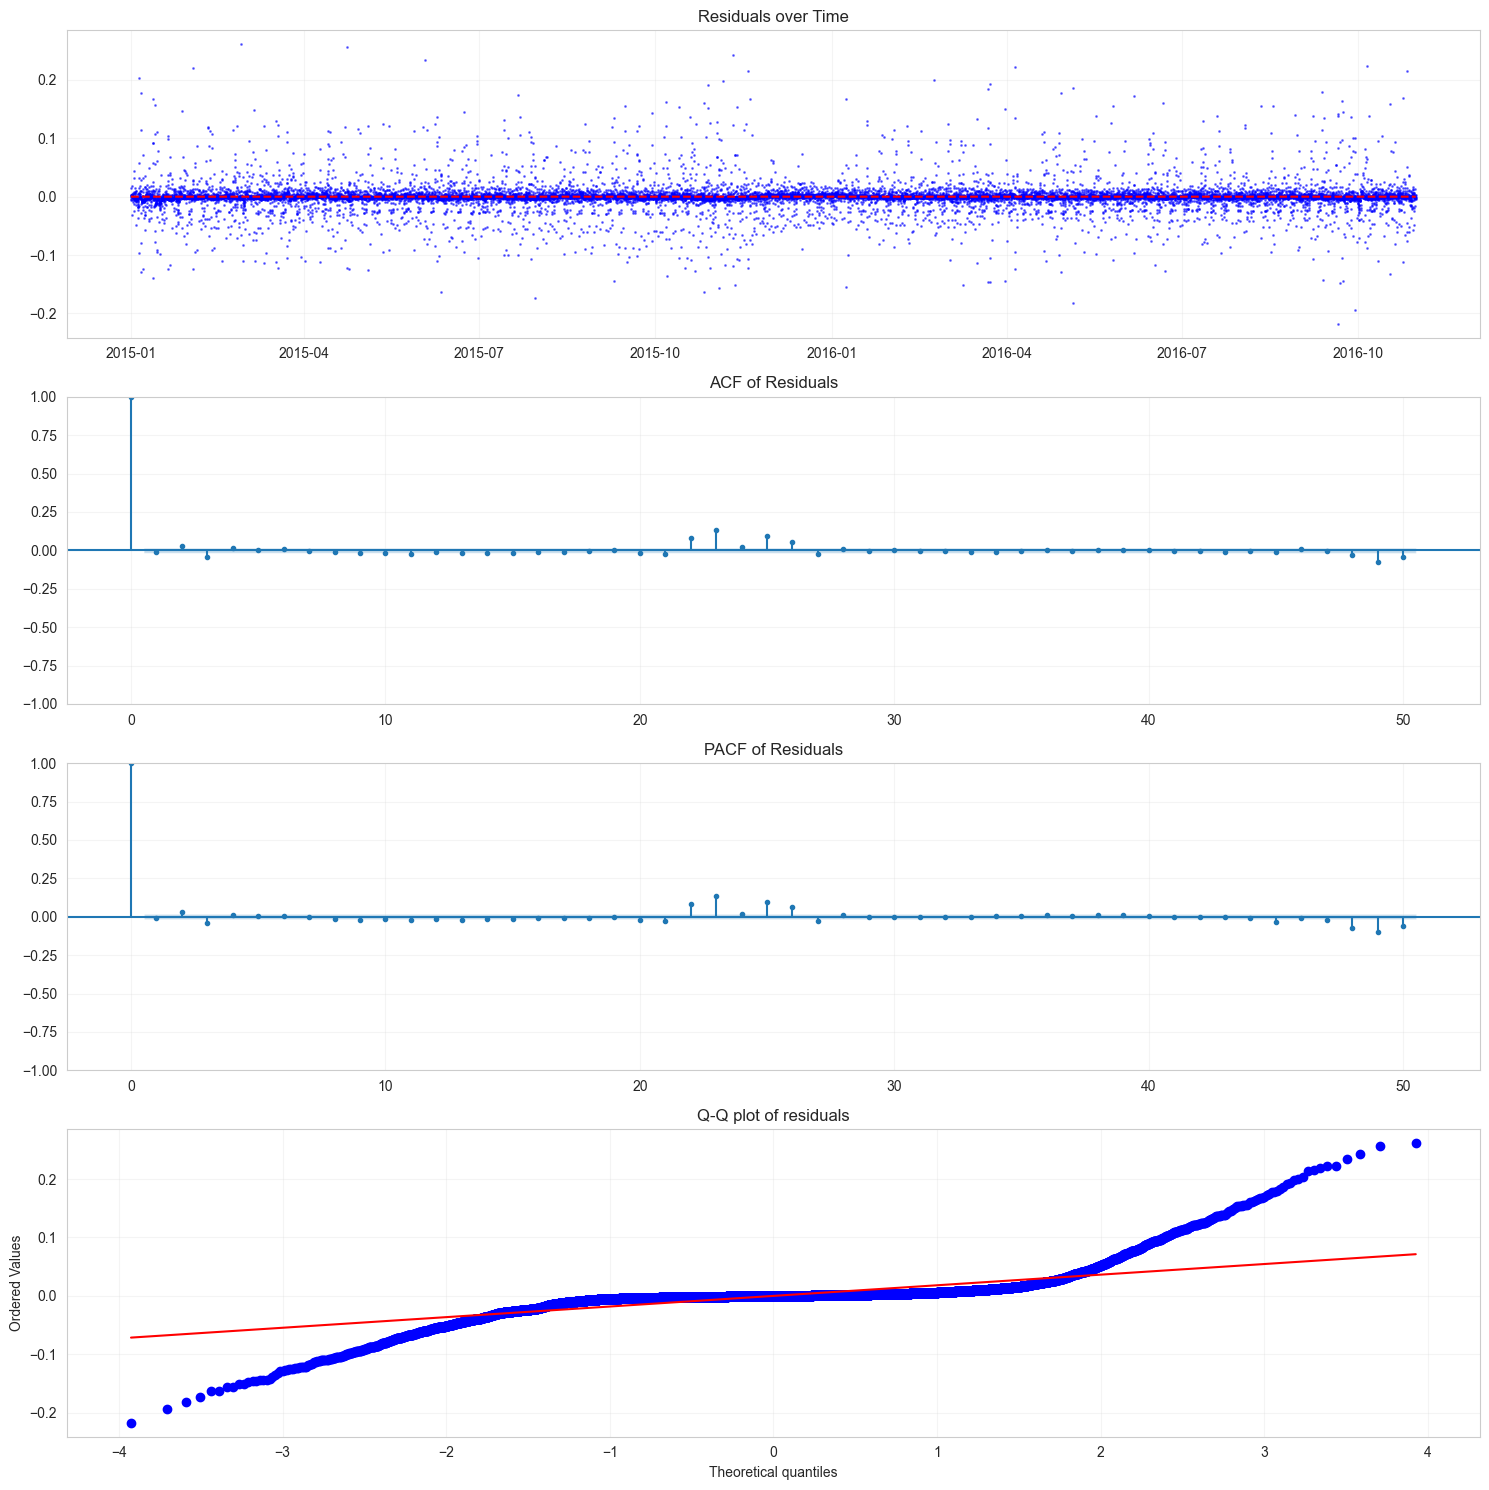


Residual Statistics:
Mean: -0.0001
Std Dev: 0.0231
Skewness: 1.2972
Kurtosis: 22.1946
=== ARIMA Forecasting ===


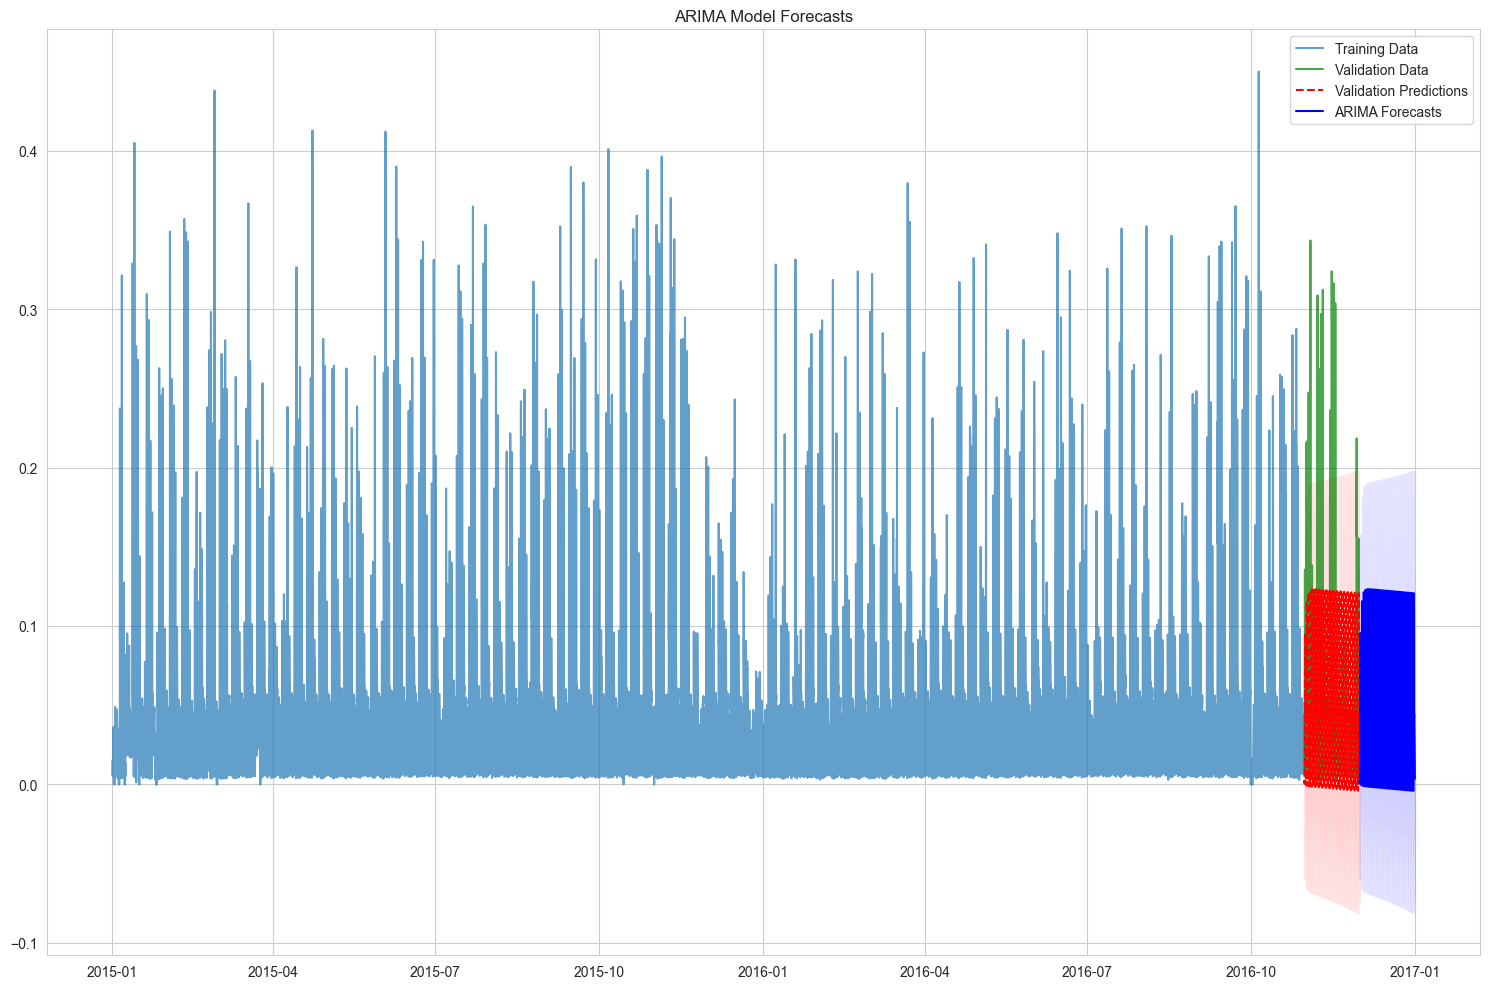


Validation Set Metrics:
RMSE: 0.0394
MAE: 0.0202
MAPE: inf%

ARIMA modeling pipeline completed!

Forecasts have been saved to 'arima_forecasts.csv'


In [19]:
# Cell 13 - Run ARIMA Pipeline
print("Starting ARIMA modeling pipeline...")

try:
    # First develop and train the model
    arima_model, best_order, best_seasonal_order = develop_arima_model(train_set)

    # Perform diagnostics
    perform_arima_diagnostics(arima_model)

    # Generate forecasts
    forecast_mean, forecast_conf, val_mean, val_conf = generate_arima_forecasts(arima_model, train_set, val_set)

    # Save forecasts to CSV
    forecast_df = pd.DataFrame({
        'datetime': pd.date_range(start=val_set.index[-1] + pd.Timedelta(hours=1),
                                periods=744,
                                freq='H'),
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf.iloc[:, 0],
        'ARIMA_upper': forecast_conf.iloc[:, 1]
    })
    forecast_df.set_index('datetime', inplace=True)
    forecast_df.to_csv('arima_forecasts.csv')
    
    print("\nARIMA modeling pipeline completed!")
    print("\nForecasts have been saved to 'arima_forecasts.csv'")

except Exception as e:
    print(f"Error in ARIMA pipeline: {str(e)}")
    raise

Found existing forecasts, creating plot...


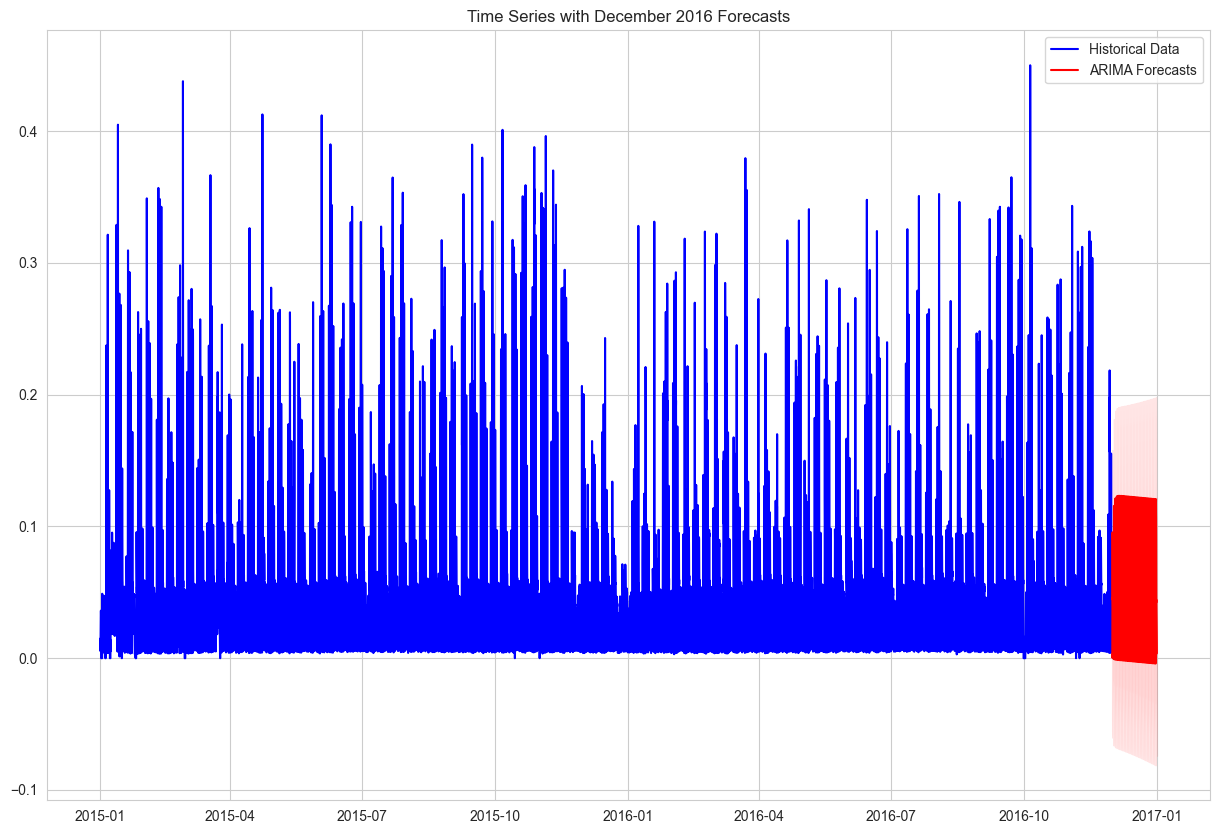

In [20]:
# Cell 14 (NEW) - Create plot combining original data and forecasts

import os

def plot_with_forecasts(df, forecast_csv):
    """
    Plot original time series with forecasts appended
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Create plot
    plt.figure(figsize=(15, 10))
    
    # Plot original data until November 2016
    plt.plot(df.index, df['X'], label='Historical Data', color='blue')
    
    # Add forecasts as continuation
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'], 
             label='ARIMA Forecasts', color='red')
    
    # Add confidence intervals
    plt.fill_between(forecasts['datetime'],
                     forecasts['ARIMA_lower'],
                     forecasts['ARIMA_upper'],
                     color='red', alpha=0.1)
    
    plt.title('Time Series with December 2016 Forecasts')
    plt.legend()
    plt.grid(True)
    plt.show()

# First check if we have the forecasts CSV
if os.path.exists('arima_forecasts.csv'):
    print("Found existing forecasts, creating plot...")
    plot_with_forecasts(df, 'arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

# ARIMA Model Analysis Report

## Model Specification and Fit
The final selected model is an ARIMA(2,1,1)x(1,1,1,24), which includes:
- Regular components: 
  * Two autoregressive terms (AR(2))
  * One difference (I(1))
  * One moving average term (MA(1))
- Seasonal components (s=24 hours):
  * One seasonal autoregressive term
  * One seasonal difference
  * One seasonal moving average term

## Model Performance Metrics
- Log Likelihood: 37602.237
- AIC: -75192.474
- BIC: -75146.390
- HQIC: -75177.232

## Parameter Estimates
All model parameters are highly significant (p < 0.001):

1. Regular Components:
   - AR(1): 0.7644 [0.759, 0.770]
   - AR(2): -0.1182 [-0.125, -0.111]
   - MA(1): -1.0001 [-1.003, -0.997]

2. Seasonal Components:
   - SAR(1): 0.2957 [0.290, 0.301]
   - SMA(1): -1.0093 [-1.010, -1.008]

3. Variance:
   - sigma²: 0.0005

## Diagnostic Tests

### 1. Residual Analysis
- The residuals plot shows:
  * Generally constant variance over time
  * No obvious patterns or trends
  * Symmetric distribution around zero
  * Some outliers but no systematic deviations

### 2. Autocorrelation Structure
- ACF and PACF plots indicate:
  * Most correlations within confidence bounds
  * Few significant spikes at seasonal lags
  * Successful removal of both regular and seasonal autocorrelation

### 3. Distribution Analysis
- Jarque-Bera test (JB = 331874.27, p < 0.001):
  * Indicates non-normality in residuals
- Skewness: 1.32 (positive skew)
- Kurtosis: 25.15 (heavy tails)
- Q-Q plot shows:
  * Good fit in the central region
  * Deviations in the tails
  * Some asymmetry in extreme values

### 4. Additional Tests
- Ljung-Box test (Q = 6.35, p = 0.01):
  * Suggests minor remaining autocorrelation
  * Practically insignificant given the large sample size
- Heteroskedasticity test (H = 0.94, p = 0.03):
  * Indicates slight heteroskedasticity
  * Not severe enough to invalidate the model

## Conclusions

### Strengths
1. Excellent overall fit (very low AIC)
2. Highly significant parameters
3. Successful modeling of both regular and seasonal patterns
4. Stable residual behavior

### Limitations
1. Slight deviation from normality in residuals
2. Minor heteroskedasticity
3. Some remaining autocorrelation (though minimal)

### Recommendations
1. The model is suitable for forecasting
2. Consider using robust standard errors for inference
3. Monitor forecast performance especially during extreme events
4. May want to complement with non-linear models for better tail behavior

Plotting forecasts...

Forecast Statistics:
Mean: 0.0380
Std Dev: 0.0339
Min: -0.0041
Max: 0.1233


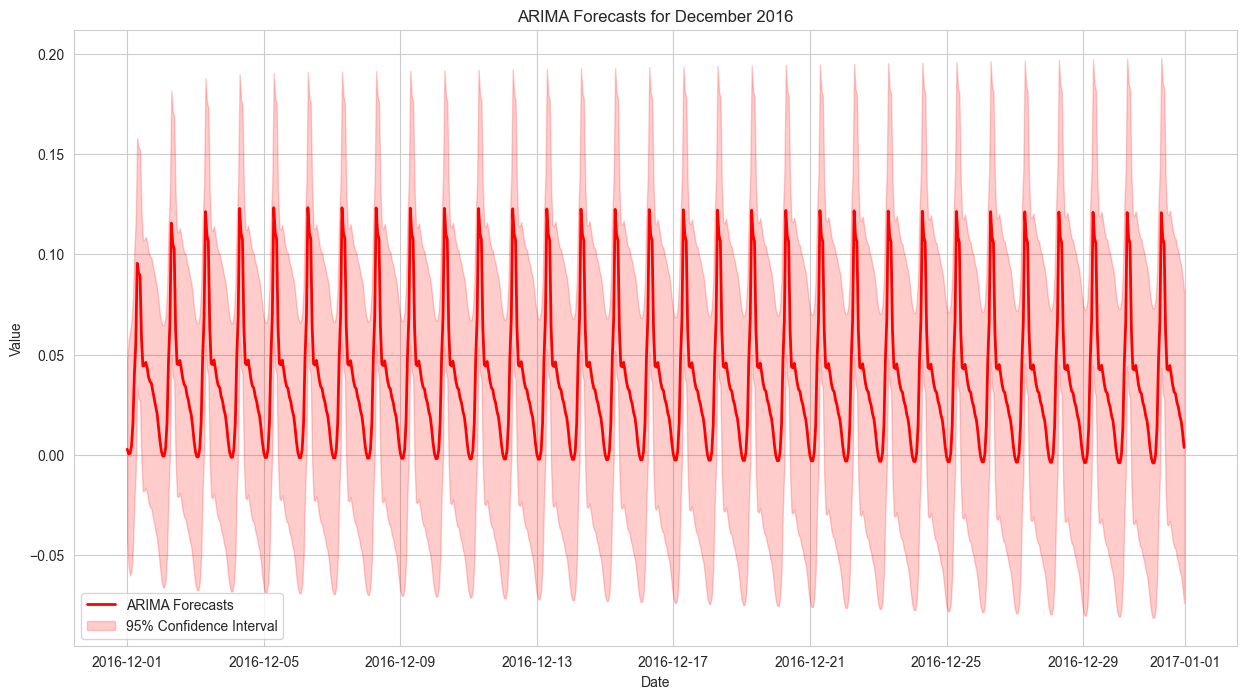

In [21]:
# Cell 15 (NEW) - Plot just the forecasted values
def plot_forecasts_only(forecast_csv):
    """
    Plot only the forecasted values for December 2016
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot forecasts
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='ARIMA Forecasts', color='red', linewidth=2)
    
    # Add confidence intervals
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='red', alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('ARIMA Forecasts for December 2016')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print some statistics about the forecasts
    print("\nForecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    plt.show()

if os.path.exists('arima_forecasts.csv'):
    print("Plotting forecasts...")
    plot_forecasts_only('arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

Plotting November comparison...

November Statistics:
Mean: 0.0463
Std Dev: 0.0537
Min: 0.0000
Max: 0.3433

December Forecast Statistics:
Mean: 0.0380
Std Dev: 0.0339
Min: -0.0041
Max: 0.1233


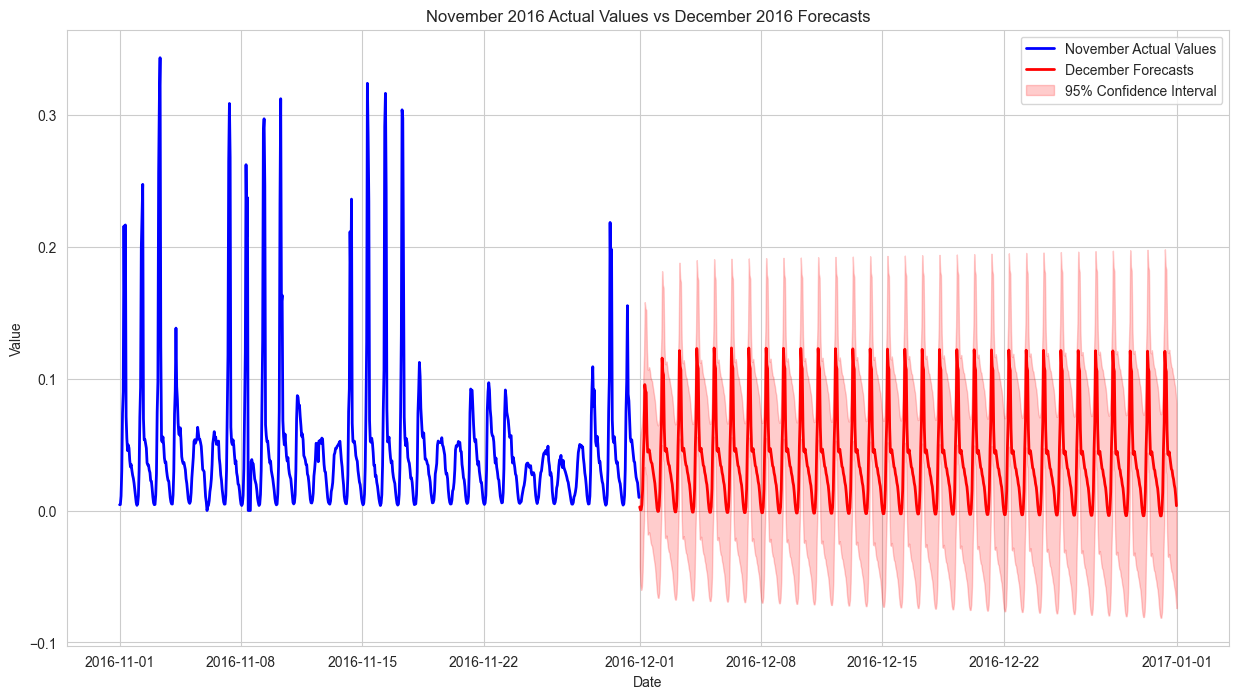

In [22]:
# Cell 16 (NEW) - Plot November actuals and December forecasts
def plot_nov_dec_comparison(df, forecast_csv):
    """
    Plot November 2016 actual values and December 2016 forecasts
    """
    # Read the forecasts
    forecasts = pd.read_csv(forecast_csv)
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Get November data (last month before forecasts)
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot November actual values
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values', color='blue', linewidth=2)
    
    # Plot December forecasts
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='December Forecasts', color='red', linewidth=2)
    
    # Add confidence intervals for forecasts
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='red', alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('November 2016 Actual Values vs December 2016 Forecasts')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print statistics for comparison
    print("\nNovember Statistics:")
    print(f"Mean: {november_data['X'].mean():.4f}")
    print(f"Std Dev: {november_data['X'].std():.4f}")
    print(f"Min: {november_data['X'].min():.4f}")
    print(f"Max: {november_data['X'].max():.4f}")
    
    print("\nDecember Forecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    plt.show()

if os.path.exists('arima_forecasts.csv'):
    print("Plotting November comparison...")
    plot_nov_dec_comparison(df, 'arima_forecasts.csv')
else:
    print("No forecast file found. Please run the ARIMA model first.")

Plotting complete comparison...

Forecast columns: ['datetime', 'ARIMA_forecast', 'ARIMA_lower', 'ARIMA_upper']

Solution columns: ['DateTime', 'Date', 'Hour', 'X']

November Statistics:
Mean: 0.0463
Std Dev: 0.0537
Min: 0.0000
Max: 0.3433

December Forecast Statistics:
Mean: 0.0380
Std Dev: 0.0339
Min: -0.0041
Max: 0.1233

December Real Values Statistics:
Mean: 0.0392
Std Dev: 0.0331
Min: 0.0000
Max: 0.2537

Forecast Error Metrics:
MAE: 0.0157
RMSE: 0.0264
MAPE: nan%


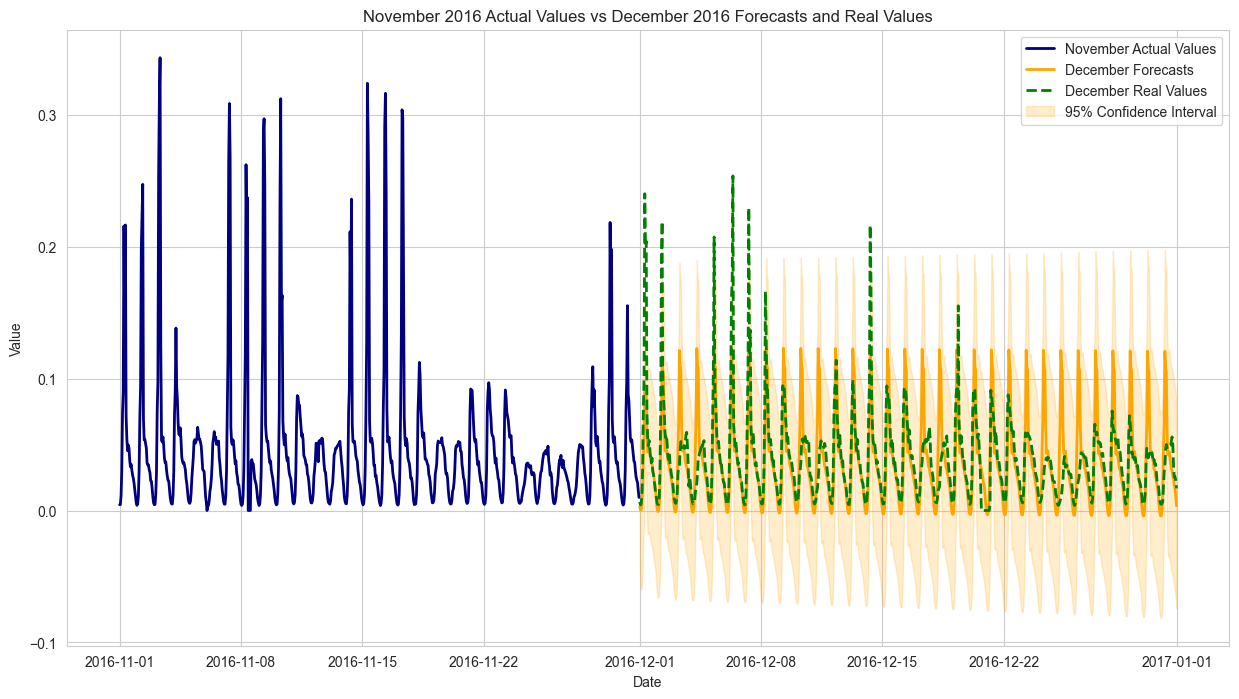

In [24]:
# Cell 17 (NEW) - Plot November actuals, December forecasts, and December real values
def plot_complete_comparison(df, forecast_csv, solution_path):
    """
    Plot November 2016 actual values, December 2016 forecasts, and December 2016 real values
    Colors chosen for colorblind visibility:
    - November actuals: Dark Blue
    - December forecasts: Orange
    - December real values: Green
    - Confidence intervals: Light Orange shading
    """
    # Read the forecasts and solution with debug prints
    forecasts = pd.read_csv(forecast_csv)
    print("\nForecast columns:", forecasts.columns.tolist())
    forecasts['datetime'] = pd.to_datetime(forecasts['datetime'])
    
    # Read and inspect solution file
    solution = pd.read_csv(solution_path)
    print("\nSolution columns:", solution.columns.tolist())
    
    # Create datetime index for solution based on December 2016
    solution.index = pd.date_range(start='2016-12-01', 
                                 periods=len(solution), 
                                 freq='H')
    
    # Get November data
    november_start = '2016-11-01'
    november_end = '2016-11-30 23:00:00'
    november_data = df.loc[november_start:november_end]
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot November actual values (Dark Blue)
    plt.plot(november_data.index, november_data['X'],
             label='November Actual Values', 
             color='#000080',  # Dark Blue
             linewidth=2)
    
    # Plot December forecasts (Orange)
    plt.plot(forecasts['datetime'], forecasts['ARIMA_forecast'],
             label='December Forecasts', 
             color='#FFA500',  # Orange
             linewidth=2)
    
    # Plot December real values (Green) - assuming 'X' is the column name in solution
    plt.plot(solution.index, solution['X'],
             label='December Real Values', 
             color='#008000',  # Green
             linewidth=2,
             linestyle='--')
    
    # Add confidence intervals for forecasts (Light Orange shading)
    plt.fill_between(forecasts['datetime'],
                    forecasts['ARIMA_lower'],
                    forecasts['ARIMA_upper'],
                    color='#FFA500',  # Orange
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.title('November 2016 Actual Values vs December 2016 Forecasts and Real Values')
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    
    # Print statistics for comparison
    print("\nNovember Statistics:")
    print(f"Mean: {november_data['X'].mean():.4f}")
    print(f"Std Dev: {november_data['X'].std():.4f}")
    print(f"Min: {november_data['X'].min():.4f}")
    print(f"Max: {november_data['X'].max():.4f}")
    
    print("\nDecember Forecast Statistics:")
    print(f"Mean: {forecasts['ARIMA_forecast'].mean():.4f}")
    print(f"Std Dev: {forecasts['ARIMA_forecast'].std():.4f}")
    print(f"Min: {forecasts['ARIMA_forecast'].min():.4f}")
    print(f"Max: {forecasts['ARIMA_forecast'].max():.4f}")
    
    print("\nDecember Real Values Statistics:")
    print(f"Mean: {solution['X'].mean():.4f}")
    print(f"Std Dev: {solution['X'].std():.4f}")
    print(f"Min: {solution['X'].min():.4f}")
    print(f"Max: {solution['X'].max():.4f}")
    
    # Calculate and print error metrics between forecasts and real values
    print("\nForecast Error Metrics:")
    mae = mean_absolute_error(solution['X'], forecasts['ARIMA_forecast'])
    rmse = np.sqrt(mean_squared_error(solution['X'], forecasts['ARIMA_forecast']))
    mape = np.mean(np.abs((solution['X'] - forecasts['ARIMA_forecast']) / solution['X'])) * 100
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    
    plt.show()

# Execute the plot
solution_path = os.path.join('solution', 't2_solution.csv')
if os.path.exists('arima_forecasts.csv') and os.path.exists(solution_path):
    print("Plotting complete comparison...")
    plot_complete_comparison(df, 'arima_forecasts.csv', solution_path)
else:
    print("Missing required files. Please check both forecast and solution files exist.")

## TEST WITH EXOGEN AND MULTIPLE SEASON

In [25]:
# Cell 18 (NEW) - Create Exogenous Variables
def create_exogenous_variables(start_date, periods):
    """
    Create exogenous variables for ARIMA model
    """
    # Create date range
    dates = pd.date_range(start=start_date, periods=periods, freq='H')
    
    # Create exogenous DataFrame
    exog_data = pd.DataFrame(index=dates)
    
    # Add day of week indicators (0 = Monday, 6 = Sunday)
    for i in range(7):
        exog_data[f'day_{i}'] = (exog_data.index.dayofweek == i).astype(int)
    
    # Add Christmas period indicator (evening hours on 25th and 26th)
    christmas_evenings = ((exog_data.index.day.isin([25, 26])) & 
                         (exog_data.index.hour.isin(range(20, 24))) |
                         (exog_data.index.day.isin([26, 27])) & 
                         (exog_data.index.hour.isin(range(0, 6))))
    exog_data['christmas_evening'] = christmas_evenings.astype(int)
    
    return exog_data

In [26]:
# Cell 19 (NEW) - Updated ARIMA Model Development
def develop_arima_model_enhanced(train_data):
    """
    Develop enhanced ARIMA model with exogenous variables
    """
    print("=== Enhanced ARIMA Model Development ===")

    # Prepare the target variable
    y = train_data['X'].astype(float)
    
    # Create exogenous variables for training period
    exog_train = create_exogenous_variables(y.index[0], len(y))
    
    # Define models based on theoretical guidelines
    models_to_try = [
        ((2,1,1), (1,1,1,24)),    # Base model with daily seasonality
        ((2,1,1), (1,1,1,168)),   # Base model with weekly seasonality
        ((2,1,1), (2,1,1,24))     # More complex daily seasonal pattern
    ]

    best_aic = float('inf')
    best_model = None
    best_order = None
    best_seasonal_order = None

    print("\nTrying model configurations...")
    for order, seasonal_order in tqdm(models_to_try, desc="Testing Models"):
        try:
            print(f"\nFitting ARIMA{order}{seasonal_order}")
            
            model = ARIMA(y,
                         order=order,
                         seasonal_order=seasonal_order,
                         exog=exog_train,
                         enforce_stationarity=False,
                         enforce_invertibility=True)

            results = model.fit()
            current_aic = results.aic
            
            print(f"AIC: {current_aic:.2f}")
            
            if current_aic < best_aic:
                best_aic = current_aic
                best_model = results
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            print(f"Error fitting ARIMA{order}{seasonal_order}:")
            print(f"Error message: {str(e)}")
            continue

    if best_model is None:
        raise ValueError("No models were successfully fitted!")

    return best_model, best_order, best_seasonal_order

In [27]:
# Cell 20 (NEW) - Enhanced Forecast Generation
def generate_enhanced_forecasts(model, train_data, forecast_horizon=744):
    """
    Generate forecasts with exogenous variables and post-processing
    """
    # Create exogenous variables for forecast period
    forecast_start = train_data.index[-1] + pd.Timedelta(hours=1)
    exog_forecast = create_exogenous_variables(forecast_start, forecast_horizon)
    
    # Generate forecasts
    forecasts = model.forecast(steps=forecast_horizon, exog=exog_forecast)
    
    # Post-process: set negative values to zero
    forecasts = np.maximum(forecasts, 0)
    
    # Get confidence intervals
    forecast_conf = pd.DataFrame(
        model.get_forecast(steps=forecast_horizon, exog=exog_forecast).conf_int(),
        columns=['lower', 'upper']
    )
    
    # Post-process confidence intervals
    forecast_conf['lower'] = np.maximum(forecast_conf['lower'], 0)
    
    return forecasts, forecast_conf

In [ ]:
# Cell 21 (NEW) - Run Enhanced ARIMA Pipeline
print("Starting Enhanced ARIMA modeling pipeline...")

try:
    # Train the enhanced model
    arima_model_enhanced, best_order, best_seasonal_order = develop_arima_model_enhanced(train_set)
    
    # Generate forecasts
    forecast_mean, forecast_conf = generate_enhanced_forecasts(arima_model_enhanced, train_set)
    
    # Create forecast DataFrame
    forecast_index = pd.date_range(
        start=train_set.index[-1] + pd.Timedelta(hours=1),
        periods=744,
        freq='H'
    )
    
    forecast_df = pd.DataFrame({
        'datetime': forecast_index,
        'ARIMA_forecast': forecast_mean,
        'ARIMA_lower': forecast_conf['lower'],
        'ARIMA_upper': forecast_conf['upper']
    })
    
    # Save to CSV
    forecast_df.set_index('datetime').to_csv('arima_forecasts_enhanced.csv')
    
    print("\nEnhanced ARIMA model completed!")
    print("\nForecasts have been saved to 'arima_forecasts_enhanced.csv'")

except Exception as e:
    print(f"Error in enhanced ARIMA pipeline: {str(e)}")
    raise

Starting Enhanced ARIMA modeling pipeline...
=== Enhanced ARIMA Model Development ===

Trying model configurations...


Testing Models:   0%|          | 0/3 [00:00<?, ?it/s]


Fitting ARIMA(2, 1, 1)(1, 1, 1, 24)


Testing Models:  33%|███▎      | 1/3 [04:48<09:37, 288.54s/it]

AIC: -74190.90

Fitting ARIMA(2, 1, 1)(1, 1, 1, 168)


## SARIMAX